#**PGExplainer- Loan-Datensatz**

In dieser Arbeitsmappe wird das Tuning und Training des PGExplainers durchgeführt.

Paper: Luo, Dongsheng u. a. (2020): Parameterized explainer for graph neural network. In: Advances
in neural information processing systems 33, 19620–19631.

Docu: https://diveintographs.readthedocs.io/en/latest/xgraph/method.html#dig.xgraph.method.PGExplainer

## Funktionsweise

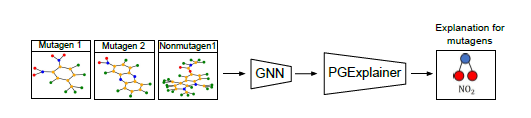

1. GNN trainieren auf einem Datensatz
2. Trainiertes GNN als Input für PGExplainer

Besonderheiten des PGExplainer:
- Globales Verständnis der von einem GNN gemachten Vorhersagen
- allgemeiner Erklärer (auf verschiedene GNN Anwendbar)
- Nutzt generatives probablistisches Modell zur Erstellung von Erklärungen -> Aufgdecken von zugrundeliegenden Strukturen, welche in Form von Kantenverteilugnen dargestellt werden
- Generierungsprozess wird mit einem deep NN parametrisiert, um verallgemeinerung zu erreichen (-> gelernten Parameter werden von allen Instanzen gleich verwendet)

Input
Top-K

Top-K gibt die Anzahl der Edges an, welche als wichtig zu bestimmen sind. In Kombination mit der durch den Explainer bestimmten Edge-Mask wird ein Grenzwert berechnet. Alle Edges, welche unter diesem liegen werden aussortiert. Hieraus kann eine Liste mit Knoten erstellt werden, welche besonders relevant für die Vorhersage des Models sind. Desto größer Top-K gewählt wird, desto mehr Knoten werden als relevant gewählt werden. Dies widerspricht der Anforderung an eine Erklärung möglichst wenige aber dafür hoch relevante Begründungen zu geben. Wird Top-K zu niedrig gewählt werden, kann es passieren das relevante Knoten aussortiert werden und die Erklärung sehr verkürzt oder unvollständig ist. Wichtige Faktoren für die Vorhersagen eines Models können dann nicht erkannt werden.

Output
Related Preds

Mask: Sicherheit der Vorhersage durch das GNN-Model bei Subgraph mit durch den Explainer als relevant markierten Knoten für die Ziel-Klasse (welche als am Wahrscheinlichsten durch das Model bei Input des gesamten Graphs ermittelt wurde)

Maskout: Sicherheit der Vorhersage durch das GNN-Model bei Subgraph mit durch den Explainer als irrelevant markierten Knoten (welche als am Wahrscheinlichsten durch das Model bei Input des gesamten Graphs ermittelt wurde)

Sparsity: Spärlichkeit der Lösung. 1 Keine Knoten wurden gewählt, 0 Alle Knoten wurden gewählt

Evalutaitonsmetrike:
Fidelity+ (Fidelity)

Hohe Werte bedeuten, dass durch Entfernen der unwichtigen Knoten nicht viel an der Vorhersagewahrscheinlichkeit des Modells geändert wurde. Aus diesem Grund lassen hier hohe Werte auf eine gute Erklärung des Explainers zurücksschließen.

Fidelity- (Fidelity_inv)

Niedrige Werte Bedeuten dass durch Entfernen der wichtigen Knoten die Vorhersagewahrscheinlichkeiten stark beeinflusst wurden. Hier sind daher niedrige Werte Ausdruck für eine gute Erklärung.
 

In [ ]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric==1.7.2

In [ ]:
%%capture
#!pip install dive-into-graphs

In [ ]:
%%capture
!git clone https://github.com/divelab/DIG.git
%cd DIG
!pip install .

In [ ]:
%%capture
!pip install pm4py

In [ ]:
# Hauptordner-Pfad
import torch
from pathlib import Path
path = Path("/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM")
%cd "/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM" 

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import joblib
# Module für das Preprocessing der verwendeten Datensätze
from preprocessing.loanApplication import *
from preprocessing.reviewSynthetic import *

from models.gcn3_neu import *


from utilities import GGNNExplainerUtilies
from dig.xgraph.method import PGExplainer
from torch_geometric.data.batch import Batch
from dig.xgraph.evaluation import XCollector
from utilities_pgexplainer_tuning import run_tuning, save_hyperparam_results, split_dataset_2_8, visual_tuning_results
from train_gcn import load_gcn_key, load_gcn

In [ ]:
# Verwendete Laufzeit-Umgebung definieren (GPU oder CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Variablen

Hier sind alle Variablen zusammengefasst. Vor Ausführen der Datei können hier Konfigurationen vorgenommen werden

In [ ]:

# ---------------------------Trainingsdatensatz ------------------------
test_len = 100

# ---------------------------Variablen Model---------------------------
hidden_channel = 100

# ---------------------------Variablen XAI Methoden---------------------------
num_classes =  2  # Anzahl der Klassen: 0: Review wurde angenommen, 1: Review wurde abgelehnt

# PGExpaleiner
path_pgexplainer =  path / "xai_methods/pgexplainer/trainiert" # Speicherort für Parameter des PGExplainer
# pgexplainer_training_name = "pgexplainer_" + dataset_name  # Name der Parameter Datei


#fast_test = ds_test[:test_len]

## PGE Explainer 

Eine Implementierung in PyTorch Geometrics existiert im Package: Dive into Graphs (DIG)

Es wurde auf den Bereits implementierten Explainer zurückgegriffen. Zur Visualisierung konnten die im Package bereitgestellten Methoden nicht verwendet werden. Diese wurde neu in Anlehnung an Haiyang Yu implementiert.



DIG: Dive into Graphs is developed by DIVE@TAMU. Contributors are Meng Liu*, Youzhi Luo*, Limei Wang*, Yaochen Xie*, Hao Yuan*, Shurui Gui*, Haiyang Yu*, Zhao Xu, Jingtun Zhang, Yi Liu, Keqiang Yan, Haoran Liu, Cong Fu, Bora Oztekin, Xuan Zhang, and Shuiwang Ji.

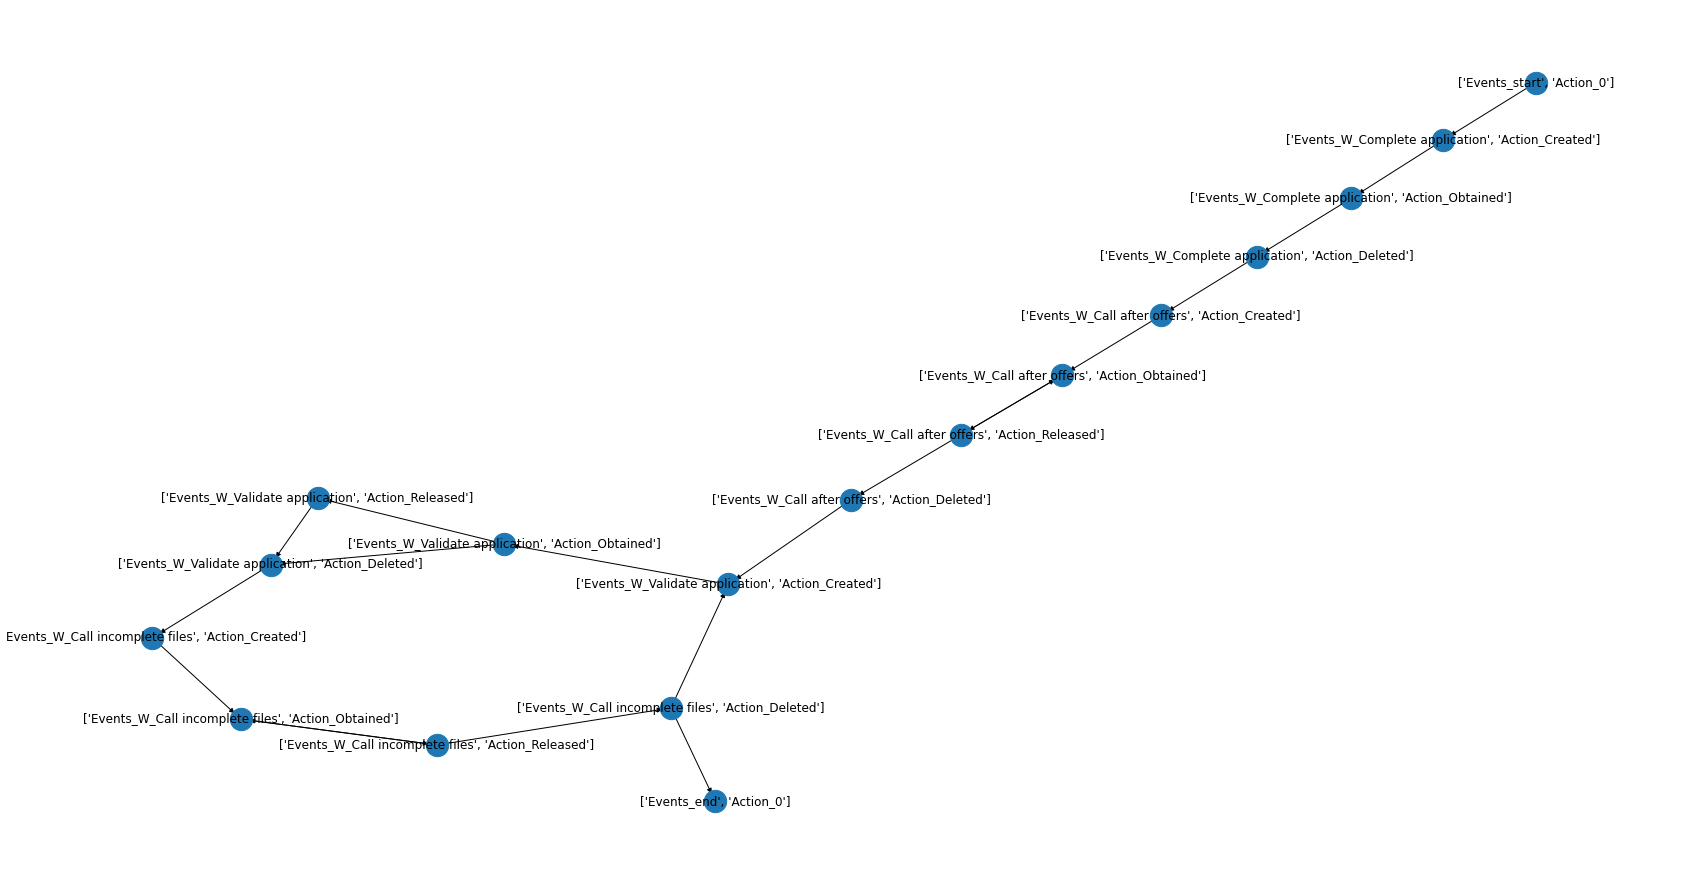

In [ ]:
# from utilities_preprocessing import  GraphDatasetHelper
# # # Namen können nur bei label encoder angezeigt werden
# # Darstellung einer Graph-Instanz vom Review-ab Datensatz
# data = ds_train[5]
# helper = GraphDatasetHelper(node_feature = feature)
# helper.visualise_dataset(data)

##Parameter Tuning

### Aktivitäten-basiert
-> loan_sn_f2_ohe_wEvents_4_nreb

#### Loan - Aktivität

In [ ]:
# Laden eines Vorverarbeiteten Datensatzes
dataset_name = "loan_sn_f2_ohe_wEvents_4_nreb" # "review_sn_f3_ohe_2"  loan_sn_f2_ohe_wEvents_4
dataset = torch.load(path / str("datasets/dataset_" + dataset_name))
feature  = joblib.load("datasets/encoder_" + dataset_name + ".joblib") 
# Model laden
input_dim = dataset[0].x.shape[1]
path_model = path / "models/"
model_name = "model_" + dataset_name

ds_train, ds_test = split_dataset_2_8(dataset)

In [ ]:
dataset_name 

'loan_sn_f2_ohe_wEvents_4_nreb'

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:10000], ds_test[:500], dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 10000/10000 [01:03<00:00, 158.72it/s]


Epoch: 0 | Loss: 42302.80791169405


100%|██████████| 10000/10000 [01:03<00:00, 156.65it/s]


Epoch: 1 | Loss: 31401.551869751886


100%|██████████| 10000/10000 [01:03<00:00, 158.08it/s]


Epoch: 2 | Loss: 24452.277280298993


100%|██████████| 10000/10000 [01:03<00:00, 158.28it/s]


Epoch: 3 | Loss: 20640.804585671052


100%|██████████| 10000/10000 [01:03<00:00, 158.54it/s]


Epoch: 4 | Loss: 15912.667209349573
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 68.14it/s]


Fidelity+: 0.1830751597881317, Fidelity-: 0.5012074708938599, Sparsity: 0.8512403964996338
save Hyperparameter


In [ ]:
param = {
    "lr": 0.001,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:10000], ds_test[:500], dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.001--------------------------


100%|██████████| 10000/10000 [01:03<00:00, 156.87it/s]


Epoch: 0 | Loss: 41653.107853030786


100%|██████████| 10000/10000 [01:03<00:00, 157.08it/s]


Epoch: 1 | Loss: 42035.52399013564


100%|██████████| 10000/10000 [01:03<00:00, 156.96it/s]


Epoch: 2 | Loss: 42207.95132222958


100%|██████████| 10000/10000 [01:03<00:00, 156.97it/s]


Epoch: 3 | Loss: 42306.982264017686


100%|██████████| 10000/10000 [01:03<00:00, 156.71it/s]


Epoch: 4 | Loss: 42567.50238879118
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 67.41it/s]


Fidelity+: 0.10738533735275269, Fidelity-: 0.5012074708938599, Sparsity: 0.8975379467010498
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:10000], ds_test[:500], dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 10000/10000 [01:04<00:00, 155.98it/s]


Epoch: 0 | Loss: 43106.23912760988


100%|██████████| 10000/10000 [01:04<00:00, 155.28it/s]


Epoch: 1 | Loss: 42097.72732777707


100%|██████████| 10000/10000 [01:04<00:00, 154.90it/s]


Epoch: 2 | Loss: 41863.45131232962


100%|██████████| 10000/10000 [01:04<00:00, 155.35it/s]


Epoch: 3 | Loss: 41197.57140163332


100%|██████████| 10000/10000 [01:04<00:00, 155.37it/s]


Epoch: 4 | Loss: 39243.5797272576
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 70.50it/s]


Fidelity+: 0.11995250731706619, Fidelity-: 0.5012074708938599, Sparsity: 0.8973296284675598
save Hyperparameter


In [ ]:
param = {
    "lr": 0.0001,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:10000], ds_test[:500], dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.0001--------------------------


100%|██████████| 10000/10000 [01:04<00:00, 155.28it/s]


Epoch: 0 | Loss: 42900.94617800973


100%|██████████| 10000/10000 [01:04<00:00, 154.74it/s]


Epoch: 1 | Loss: 42604.73631496355


100%|██████████| 10000/10000 [01:04<00:00, 155.17it/s]


Epoch: 2 | Loss: 44111.60763450898


100%|██████████| 10000/10000 [01:04<00:00, 155.12it/s]


Epoch: 3 | Loss: 45123.75320363231


100%|██████████| 10000/10000 [01:04<00:00, 155.49it/s]


Epoch: 4 | Loss: 46954.00712536834
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 70.16it/s]

Fidelity+: 0.08366507291793823, Fidelity-: 0.5012074708938599, Sparsity: 0.8976667523384094
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.1, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:10000], ds_test[:500], dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 10000/10000 [01:04<00:00, 154.89it/s]


Epoch: 0 | Loss: 53744.3180808723


100%|██████████| 10000/10000 [01:04<00:00, 155.38it/s]


Epoch: 1 | Loss: 44335.952312886715


100%|██████████| 10000/10000 [01:04<00:00, 155.16it/s]


Epoch: 2 | Loss: 36189.04597103596


100%|██████████| 10000/10000 [01:04<00:00, 155.49it/s]


Epoch: 3 | Loss: 28666.85094962269


100%|██████████| 10000/10000 [01:04<00:00, 155.14it/s]


Epoch: 4 | Loss: 26843.118500534445
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 70.86it/s]

Fidelity+: 0.18779562413692474, Fidelity-: 0.5014368295669556, Sparsity: 0.8333212733268738
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:10000], ds_test[:500], dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 10000/10000 [01:04<00:00, 155.08it/s]


Epoch: 0 | Loss: 40333.77900808933


100%|██████████| 10000/10000 [01:04<00:00, 154.28it/s]


Epoch: 1 | Loss: 29791.405750308186


100%|██████████| 10000/10000 [01:04<00:00, 154.62it/s]


Epoch: 2 | Loss: 24448.11790109682


100%|██████████| 10000/10000 [01:04<00:00, 154.42it/s]


Epoch: 3 | Loss: 18762.750132687623


100%|██████████| 10000/10000 [01:04<00:00, 154.51it/s]


Epoch: 4 | Loss: 15511.213881199015
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 67.29it/s]


Fidelity+: 0.15297602117061615, Fidelity-: 0.5012074708938599, Sparsity: 0.8634398579597473
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:10000], ds_test[:500], dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 10000/10000 [01:04<00:00, 154.28it/s]


Epoch: 0 | Loss: 42515.920071359724


100%|██████████| 10000/10000 [01:04<00:00, 154.92it/s]


Epoch: 1 | Loss: 32235.5042136088


100%|██████████| 10000/10000 [01:04<00:00, 154.88it/s]


Epoch: 2 | Loss: 23798.232933672145


100%|██████████| 10000/10000 [01:04<00:00, 155.03it/s]


Epoch: 3 | Loss: 18299.555863741785


100%|██████████| 10000/10000 [01:04<00:00, 154.88it/s]


Epoch: 4 | Loss: 15617.82641332969
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 70.04it/s]


Fidelity+: 0.16382548213005066, Fidelity-: 0.5007827877998352, Sparsity: 0.8501854538917542
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.00005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:10000], ds_test[:500], dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 10000/10000 [01:04<00:00, 155.98it/s]


Epoch: 0 | Loss: 41976.91988155991


100%|██████████| 10000/10000 [01:04<00:00, 156.00it/s]


Epoch: 1 | Loss: 31110.76881369576


100%|██████████| 10000/10000 [01:04<00:00, 155.93it/s]


Epoch: 2 | Loss: 24479.575764529407


100%|██████████| 10000/10000 [01:04<00:00, 156.12it/s]


Epoch: 3 | Loss: 19364.28377316706


100%|██████████| 10000/10000 [01:05<00:00, 152.45it/s]


Epoch: 4 | Loss: 15610.56004289724
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 70.87it/s]


Fidelity+: 0.18277889490127563, Fidelity-: 0.5011858940124512, Sparsity: 0.8456130623817444
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 3.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:10000], ds_test[:500], dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 10000/10000 [01:03<00:00, 156.57it/s]


Epoch: 0 | Loss: 43434.174739181064


100%|██████████| 10000/10000 [01:03<00:00, 156.49it/s]


Epoch: 1 | Loss: 31895.844929065555


100%|██████████| 10000/10000 [01:03<00:00, 156.41it/s]


Epoch: 2 | Loss: 22631.65169222653


100%|██████████| 10000/10000 [01:04<00:00, 155.75it/s]


Epoch: 3 | Loss: 17233.501686029136


100%|██████████| 10000/10000 [01:03<00:00, 156.34it/s]


Epoch: 4 | Loss: 15618.220562044531
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 69.94it/s]


Fidelity+: 0.17585164308547974, Fidelity-: 0.5007827877998352, Sparsity: 0.8393508195877075
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 10
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:10000], ds_test[:500], dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 10000/10000 [01:04<00:00, 156.16it/s]


Epoch: 0 | Loss: 41814.034941043705


100%|██████████| 10000/10000 [01:04<00:00, 155.85it/s]


Epoch: 1 | Loss: 33015.89024317823


100%|██████████| 10000/10000 [01:04<00:00, 155.72it/s]


Epoch: 2 | Loss: 26838.805638201535


100%|██████████| 10000/10000 [01:04<00:00, 156.04it/s]


Epoch: 3 | Loss: 24995.75401851721


100%|██████████| 10000/10000 [01:04<00:00, 155.81it/s]


Epoch: 4 | Loss: 20054.495101137087


100%|██████████| 10000/10000 [01:04<00:00, 155.93it/s]


Epoch: 5 | Loss: 15394.16490742378


100%|██████████| 10000/10000 [01:04<00:00, 155.85it/s]


Epoch: 6 | Loss: 13710.899523964152


100%|██████████| 10000/10000 [01:04<00:00, 156.02it/s]


Epoch: 7 | Loss: 15235.359561400488


100%|██████████| 10000/10000 [01:04<00:00, 155.42it/s]


Epoch: 8 | Loss: 14711.29569713492


100%|██████████| 10000/10000 [01:04<00:00, 155.47it/s]


Epoch: 9 | Loss: 13197.742614332587
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 67.63it/s]

Fidelity+: 0.19309788942337036, Fidelity-: 0.5007827877998352, Sparsity: 0.8353846073150635
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 4.0,
    "epochs": 5
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:10000], ds_test[:500], dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 10000/10000 [01:04<00:00, 156.15it/s]


Epoch: 0 | Loss: 42500.03911857866


100%|██████████| 10000/10000 [01:04<00:00, 155.86it/s]


Epoch: 1 | Loss: 32872.21421872266


100%|██████████| 10000/10000 [01:04<00:00, 155.87it/s]


Epoch: 2 | Loss: 25948.76622318104


100%|██████████| 10000/10000 [01:04<00:00, 155.69it/s]


Epoch: 3 | Loss: 23440.80474167131


100%|██████████| 10000/10000 [01:04<00:00, 155.70it/s]


Epoch: 4 | Loss: 19361.829452730715
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 70.54it/s]


Fidelity+: 0.15218955278396606, Fidelity-: 0.5012074708938599, Sparsity: 0.8659042119979858
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 8.0,
    "t1": 4.0,
    "epochs": 10
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:10000], ds_test[:500], dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 10000/10000 [01:04<00:00, 155.43it/s]


Epoch: 0 | Loss: 42405.32903396152


100%|██████████| 10000/10000 [01:04<00:00, 155.20it/s]


Epoch: 1 | Loss: 36427.893699714914


100%|██████████| 10000/10000 [01:04<00:00, 155.11it/s]


Epoch: 2 | Loss: 30361.032793764025


100%|██████████| 10000/10000 [01:04<00:00, 155.23it/s]


Epoch: 3 | Loss: 24308.779733957723


100%|██████████| 10000/10000 [01:04<00:00, 154.94it/s]


Epoch: 4 | Loss: 21181.563292987645


100%|██████████| 10000/10000 [01:04<00:00, 154.92it/s]


Epoch: 5 | Loss: 17000.27562526986


100%|██████████| 10000/10000 [01:04<00:00, 155.20it/s]


Epoch: 6 | Loss: 14063.143626008183


100%|██████████| 10000/10000 [01:04<00:00, 155.02it/s]


Epoch: 7 | Loss: 13536.198527164757


100%|██████████| 10000/10000 [01:04<00:00, 155.37it/s]


Epoch: 8 | Loss: 13149.513729179278


100%|██████████| 10000/10000 [01:04<00:00, 154.96it/s]


Epoch: 9 | Loss: 12806.40943419002
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 70.32it/s]


Fidelity+: 0.15566426515579224, Fidelity-: 0.5007827877998352, Sparsity: 0.8395167589187622
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 500/500 [00:03<00:00, 152.18it/s]


Epoch: 0 | Loss: 2232.3561824038625


100%|██████████| 500/500 [00:03<00:00, 152.62it/s]


Epoch: 1 | Loss: 1754.7140692435205


100%|██████████| 500/500 [00:03<00:00, 153.84it/s]


Epoch: 2 | Loss: 1447.0292603336275


100%|██████████| 500/500 [00:03<00:00, 154.64it/s]


Epoch: 3 | Loss: 1360.6387368738651


100%|██████████| 500/500 [00:03<00:00, 152.56it/s]


Epoch: 4 | Loss: 1230.450576338917
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 68.97it/s]


Fidelity+: 0.15932296216487885, Fidelity-: 0.5245198011398315, Sparsity: 0.8945338129997253
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:31<00:00, 160.30it/s]


Epoch: 0 | Loss: 21108.128839236684


100%|██████████| 5000/5000 [00:31<00:00, 160.37it/s]


Epoch: 1 | Loss: 16535.27311132569


100%|██████████| 5000/5000 [00:31<00:00, 161.04it/s]


Epoch: 2 | Loss: 13110.15389689058


100%|██████████| 5000/5000 [00:31<00:00, 160.43it/s]


Epoch: 3 | Loss: 9957.68429855723


100%|██████████| 5000/5000 [00:33<00:00, 150.19it/s]


Epoch: 4 | Loss: 7193.330741864629
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:15<00:00, 65.88it/s]


Fidelity+: 0.19445037841796875, Fidelity-: 0.5043922066688538, Sparsity: 0.8544787764549255
save Hyperparameter


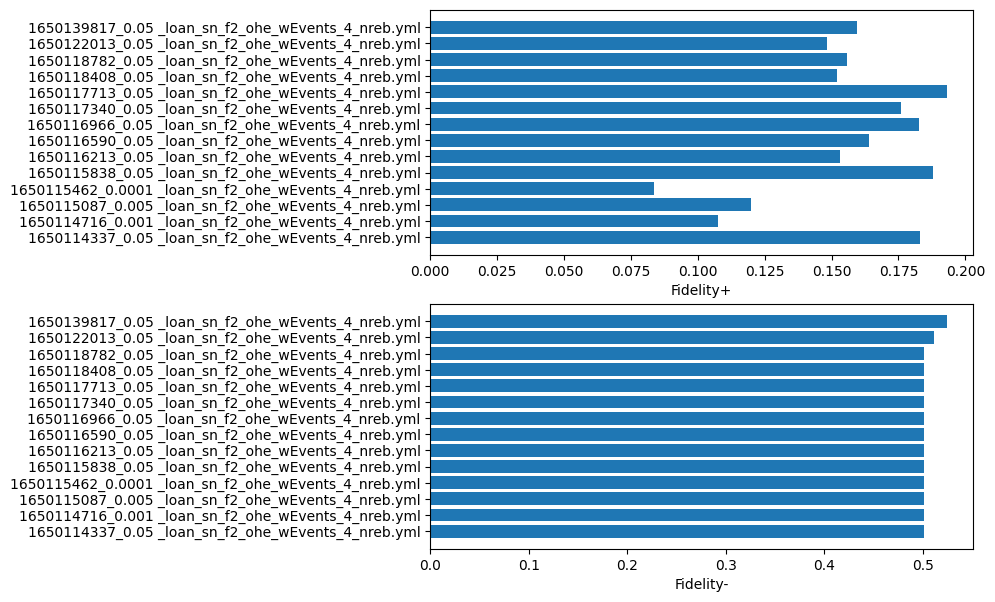

In [ ]:
visual_tuning_results(f"{dataset_name}", path)

### Event basiert
-> review_all_events_f5_ohe_2_prefix

#### Loan - Event

In [ ]:
# Laden eines Vorverarbeiteten Datensatzes
dataset_name = "loan_all_events_fall_ohe_wEvents_5_2"
dataset = torch.load(path / str("datasets/dataset_" + dataset_name))
feature  = joblib.load("datasets/encoder_" + dataset_name + ".joblib") 


#### Ganzer Graph

In [ ]:
dataset_name

'loan_all_events_fall_ohe_wEvents_5_2'

In [ ]:
# Dataset und Model
key = 0
dataset0 = dataset[key]
input_dim = dataset0[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset0)

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:33<00:00, 149.77it/s]


Epoch: 0 | Loss: 1774.164745987393


100%|██████████| 5000/5000 [00:37<00:00, 133.20it/s]


Epoch: 1 | Loss: 1630.7447129781358


100%|██████████| 5000/5000 [00:37<00:00, 134.60it/s]


Epoch: 2 | Loss: 1675.7938168920355


100%|██████████| 5000/5000 [00:37<00:00, 132.47it/s]


Epoch: 3 | Loss: 1699.182026521893


100%|██████████| 5000/5000 [00:32<00:00, 155.69it/s]


Epoch: 4 | Loss: 1703.0211272775696
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 69.68it/s]


Fidelity+: 0.0958455502986908, Fidelity-: 0.3949541449546814, Sparsity: 0.6353575587272644
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 153.34it/s]


Epoch: 0 | Loss: 1765.7779005207121


100%|██████████| 5000/5000 [00:32<00:00, 152.65it/s]


Epoch: 1 | Loss: 1628.8587967525236


100%|██████████| 5000/5000 [00:32<00:00, 153.68it/s]


Epoch: 2 | Loss: 1646.7987864915922


100%|██████████| 5000/5000 [00:32<00:00, 153.37it/s]


Epoch: 3 | Loss: 1600.3978121460823


100%|██████████| 5000/5000 [00:32<00:00, 153.56it/s]


Epoch: 4 | Loss: 2620.9609628077596
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 69.02it/s]


Fidelity+: 0.07308316975831985, Fidelity-: 0.4790077209472656, Sparsity: 0.6336839199066162
save Hyperparameter


In [ ]:
param = {
    "lr": 0.001,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.001--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 153.88it/s]


Epoch: 0 | Loss: 1758.3162384042516


100%|██████████| 5000/5000 [00:32<00:00, 153.47it/s]


Epoch: 1 | Loss: 1772.2660106206313


100%|██████████| 5000/5000 [00:32<00:00, 153.27it/s]


Epoch: 2 | Loss: 1778.981875824742


100%|██████████| 5000/5000 [00:32<00:00, 153.42it/s]


Epoch: 3 | Loss: 1800.256716159638


100%|██████████| 5000/5000 [00:34<00:00, 146.98it/s]


Epoch: 4 | Loss: 1774.6238373578526
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:15<00:00, 64.79it/s]


Fidelity+: 0.05662266165018082, Fidelity-: 0.4614631235599518, Sparsity: 0.624946653842926
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.005--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 153.62it/s]


Epoch: 0 | Loss: 1771.833191470243


100%|██████████| 5000/5000 [00:32<00:00, 153.45it/s]


Epoch: 1 | Loss: 1759.9502310743555


100%|██████████| 5000/5000 [00:32<00:00, 153.50it/s]


Epoch: 2 | Loss: 1761.6441112309694


100%|██████████| 5000/5000 [00:32<00:00, 152.97it/s]


Epoch: 3 | Loss: 1753.1341197500005


100%|██████████| 5000/5000 [00:32<00:00, 153.57it/s]


Epoch: 4 | Loss: 1723.464702380821
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 69.23it/s]


Fidelity+: 0.14506731927394867, Fidelity-: 0.3167434334754944, Sparsity: 0.6348704099655151
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 10
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 153.14it/s]


Epoch: 0 | Loss: 1761.6746375467628


100%|██████████| 5000/5000 [00:32<00:00, 153.41it/s]


Epoch: 1 | Loss: 1676.627042488195


100%|██████████| 5000/5000 [00:32<00:00, 153.18it/s]


Epoch: 2 | Loss: 1601.1278131027939


100%|██████████| 5000/5000 [00:32<00:00, 153.69it/s]


Epoch: 3 | Loss: 1623.3314355011098


100%|██████████| 5000/5000 [00:32<00:00, 153.52it/s]


Epoch: 4 | Loss: 1593.6094236002536


100%|██████████| 5000/5000 [00:32<00:00, 153.85it/s]


Epoch: 5 | Loss: 1523.8597591482103


100%|██████████| 5000/5000 [00:32<00:00, 154.14it/s]


Epoch: 6 | Loss: 1527.5654120635008


100%|██████████| 5000/5000 [00:32<00:00, 153.44it/s]


Epoch: 7 | Loss: 1568.0083976118185


100%|██████████| 5000/5000 [00:32<00:00, 153.31it/s]


Epoch: 8 | Loss: 1538.5045467664022


100%|██████████| 5000/5000 [00:32<00:00, 153.33it/s]


Epoch: 9 | Loss: 1561.963044235832
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 68.53it/s]


Fidelity+: 0.07038679718971252, Fidelity-: 0.48117443919181824, Sparsity: 0.6356338262557983
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 154.42it/s]


Epoch: 0 | Loss: 1236.1680948100984


100%|██████████| 5000/5000 [00:32<00:00, 153.64it/s]


Epoch: 1 | Loss: 1589.5049334018258


100%|██████████| 5000/5000 [00:32<00:00, 154.13it/s]


Epoch: 2 | Loss: 1325.8074566321447


100%|██████████| 5000/5000 [00:32<00:00, 153.94it/s]


Epoch: 3 | Loss: 1282.2471870938316


100%|██████████| 5000/5000 [00:32<00:00, 153.40it/s]


Epoch: 4 | Loss: 1025.1918464980554
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 69.39it/s]


Fidelity+: 0.15668374300003052, Fidelity-: 0.3720338046550751, Sparsity: 0.7688400745391846
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,  ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.005--------------------------


100%|██████████| 5000/5000 [00:33<00:00, 150.46it/s]


Epoch: 0 | Loss: 1248.6450927476399


100%|██████████| 5000/5000 [00:32<00:00, 154.35it/s]


Epoch: 1 | Loss: 1235.801608510199


100%|██████████| 5000/5000 [00:32<00:00, 154.07it/s]


Epoch: 2 | Loss: 1234.4182683895342


100%|██████████| 5000/5000 [00:32<00:00, 152.95it/s]


Epoch: 3 | Loss: 1261.3273868117249


100%|██████████| 5000/5000 [00:32<00:00, 154.14it/s]


Epoch: 4 | Loss: 1282.572112796479
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 69.14it/s]


Fidelity+: 0.051114361733198166, Fidelity-: 0.4917893707752228, Sparsity: 0.6253736615180969
save Hyperparameter


Vorhersagequalität auf Daten, welche bereits im Training verwendet wurden 

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 500/500 [00:03<00:00, 152.28it/s]


Epoch: 0 | Loss: 139.9031877927482


100%|██████████| 500/500 [00:03<00:00, 152.82it/s]


Epoch: 1 | Loss: 152.96427717152983


100%|██████████| 500/500 [00:03<00:00, 151.55it/s]


Epoch: 2 | Loss: 149.7216757745482


100%|██████████| 500/500 [00:03<00:00, 154.66it/s]


Epoch: 3 | Loss: 158.26288028803538


100%|██████████| 500/500 [00:03<00:00, 154.39it/s]


Epoch: 4 | Loss: 159.32957289618753
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 69.63it/s]


Fidelity+: 0.4201490879058838, Fidelity-: 0.0811876729130745, Sparsity: 0.6273621320724487
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 500/500 [00:03<00:00, 152.01it/s]


Epoch: 0 | Loss: 185.7860340923071


100%|██████████| 500/500 [00:03<00:00, 128.58it/s]


Epoch: 1 | Loss: 176.90292183868587


100%|██████████| 500/500 [00:03<00:00, 145.19it/s]


Epoch: 2 | Loss: 176.7938535520807


100%|██████████| 500/500 [00:03<00:00, 150.26it/s]


Epoch: 3 | Loss: 181.74250043579377


100%|██████████| 500/500 [00:03<00:00, 149.65it/s]


Epoch: 4 | Loss: 182.76641054952051
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 68.14it/s]

Fidelity+: 0.27070352435112, Fidelity-: 0.17689798772335052, Sparsity: 0.6305029392242432
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 152.07it/s]


Epoch: 0 | Loss: 1492.239130726084


100%|██████████| 5000/5000 [00:32<00:00, 152.72it/s]


Epoch: 1 | Loss: 1563.769910546951


100%|██████████| 5000/5000 [00:32<00:00, 152.41it/s]


Epoch: 2 | Loss: 1655.9710617375385


100%|██████████| 5000/5000 [00:32<00:00, 152.52it/s]


Epoch: 3 | Loss: 1725.3652012111197


100%|██████████| 5000/5000 [00:32<00:00, 152.86it/s]


Epoch: 4 | Loss: 1728.3397533722327
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 68.27it/s]


Fidelity+: 0.4229569137096405, Fidelity-: 0.10534486919641495, Sparsity: 0.6241406202316284
save Hyperparameter


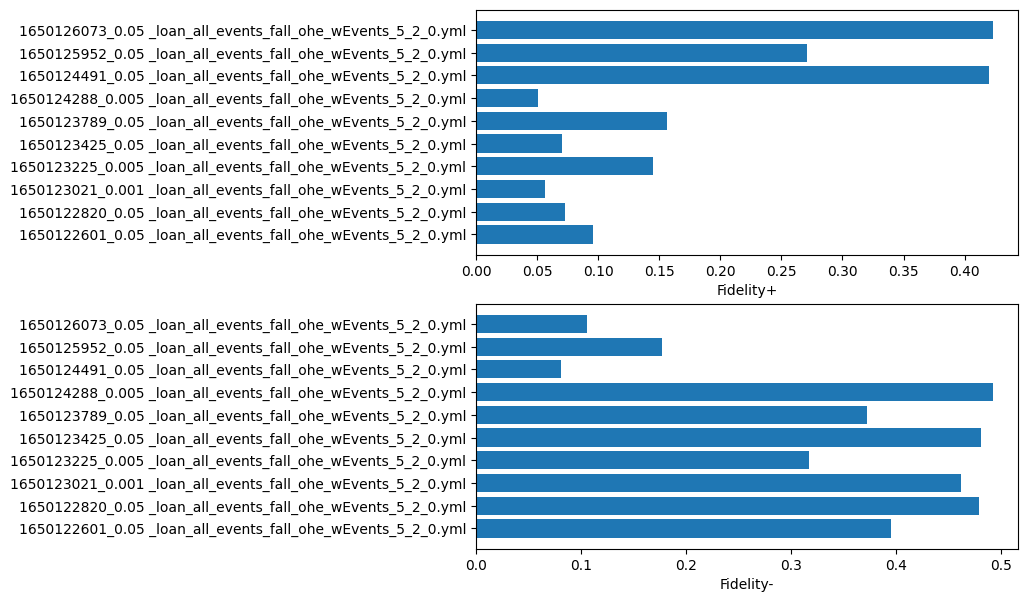

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

####Länge 4

In [ ]:
dataset_name

'loan_all_events_fall_ohe_wEvents_5_2'

In [ ]:
# Dataset und Model
key = 4
dataset4 = dataset[key]
input_dim = dataset4[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset4)

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:33<00:00, 149.73it/s]


Epoch: 0 | Loss: 3256.9255197048187


100%|██████████| 5000/5000 [00:32<00:00, 154.40it/s]


Epoch: 1 | Loss: 3250.8757370114326


100%|██████████| 5000/5000 [00:32<00:00, 155.08it/s]


Epoch: 2 | Loss: 3233.556047588587


100%|██████████| 5000/5000 [00:32<00:00, 153.30it/s]


Epoch: 3 | Loss: 3227.359369277954


100%|██████████| 5000/5000 [00:32<00:00, 153.69it/s]


Epoch: 4 | Loss: 3227.7695037424564
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 69.03it/s]


Fidelity+: 0.01569145731627941, Fidelity-: 0.05069136247038841, Sparsity: 0.5170000195503235
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 154.33it/s]


Epoch: 0 | Loss: 3256.633439719677


100%|██████████| 5000/5000 [00:32<00:00, 154.83it/s]


Epoch: 1 | Loss: 3256.213481903076


100%|██████████| 5000/5000 [00:32<00:00, 154.07it/s]


Epoch: 2 | Loss: 3254.657858788967


100%|██████████| 5000/5000 [00:32<00:00, 154.61it/s]


Epoch: 3 | Loss: 3252.479043185711


100%|██████████| 5000/5000 [00:32<00:00, 153.53it/s]


Epoch: 4 | Loss: 3249.4165402650833
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 69.25it/s]


Fidelity+: 0.017359497025609016, Fidelity-: 0.048650436103343964, Sparsity: 0.5
save Hyperparameter


In [ ]:
param = {
    "lr": 0.01,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.01--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 154.25it/s]


Epoch: 0 | Loss: 3256.8731651306152


100%|██████████| 5000/5000 [00:32<00:00, 154.69it/s]


Epoch: 1 | Loss: 3255.8880867362022


100%|██████████| 5000/5000 [00:32<00:00, 154.13it/s]


Epoch: 2 | Loss: 3253.5140258073807


100%|██████████| 5000/5000 [00:32<00:00, 153.22it/s]


Epoch: 3 | Loss: 3249.6899827718735


100%|██████████| 5000/5000 [00:32<00:00, 154.40it/s]


Epoch: 4 | Loss: 3243.2389748692513
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 69.24it/s]


Fidelity+: 0.016200002282857895, Fidelity-: 0.04980993643403053, Sparsity: 0.5
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:34<00:00, 142.91it/s]


Epoch: 0 | Loss: 3182.905342578888


100%|██████████| 5000/5000 [00:32<00:00, 151.55it/s]


Epoch: 1 | Loss: 3149.037052601576


100%|██████████| 5000/5000 [00:34<00:00, 146.08it/s]


Epoch: 2 | Loss: 3103.808779835701


100%|██████████| 5000/5000 [00:33<00:00, 151.03it/s]


Epoch: 3 | Loss: 3091.968170106411


100%|██████████| 5000/5000 [00:32<00:00, 152.37it/s]


Epoch: 4 | Loss: 3091.602786153555
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 67.59it/s]


Fidelity+: -1.1920929521291868e-10, Fidelity-: 0.06505116820335388, Sparsity: 1.0
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:34<00:00, 144.19it/s]


Epoch: 0 | Loss: 3250.215516626835


100%|██████████| 5000/5000 [00:32<00:00, 152.86it/s]


Epoch: 1 | Loss: 3245.7437886595726


100%|██████████| 5000/5000 [00:35<00:00, 138.96it/s]


Epoch: 2 | Loss: 3229.6861284971237


100%|██████████| 5000/5000 [00:36<00:00, 137.92it/s]


Epoch: 3 | Loss: 3216.779947042465


100%|██████████| 5000/5000 [00:33<00:00, 149.80it/s]


Epoch: 4 | Loss: 3212.1505932211876
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:17<00:00, 58.34it/s]


Fidelity+: 0.015102360397577286, Fidelity-: 0.04960785433650017, Sparsity: 0.5005000233650208
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 154.75it/s]


Epoch: 0 | Loss: 3188.9112770557404


100%|██████████| 5000/5000 [00:32<00:00, 154.04it/s]


Epoch: 1 | Loss: 3161.9270726442337


100%|██████████| 5000/5000 [00:32<00:00, 154.17it/s]


Epoch: 2 | Loss: 3116.854399651289


100%|██████████| 5000/5000 [00:32<00:00, 153.77it/s]


Epoch: 3 | Loss: 3100.3653608858585


100%|██████████| 5000/5000 [00:32<00:00, 154.17it/s]


Epoch: 4 | Loss: 3099.722979724407
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:15<00:00, 63.89it/s]


Fidelity+: 1.1920929521291868e-10, Fidelity-: 0.0666896179318428, Sparsity: 1.0
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 155.21it/s]


Epoch: 0 | Loss: 3256.697305560112


100%|██████████| 5000/5000 [00:32<00:00, 154.62it/s]


Epoch: 1 | Loss: 3250.513027012348


100%|██████████| 5000/5000 [00:32<00:00, 155.12it/s]


Epoch: 2 | Loss: 3234.8958051502705


100%|██████████| 5000/5000 [00:32<00:00, 154.87it/s]


Epoch: 3 | Loss: 3226.509857624769


100%|██████████| 5000/5000 [00:32<00:00, 155.06it/s]


Epoch: 4 | Loss: 3225.2731822133064
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 69.11it/s]


Fidelity+: 0.011570903472602367, Fidelity-: 0.05565187707543373, Sparsity: 0.5690000057220459
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 500/500 [00:03<00:00, 152.87it/s]


Epoch: 0 | Loss: 325.99293196201324


100%|██████████| 500/500 [00:03<00:00, 126.36it/s]


Epoch: 1 | Loss: 325.35003900527954


100%|██████████| 500/500 [00:03<00:00, 144.09it/s]


Epoch: 2 | Loss: 323.453131377697


100%|██████████| 500/500 [00:03<00:00, 155.87it/s]


Epoch: 3 | Loss: 322.8030391931534


100%|██████████| 500/500 [00:03<00:00, 155.13it/s]


Epoch: 4 | Loss: 322.77294343709946
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 68.65it/s]


Fidelity+: 0.015636203810572624, Fidelity-: 0.04822727292776108, Sparsity: 0.5049999952316284
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.005--------------------------


100%|██████████| 500/500 [00:03<00:00, 149.36it/s]


Epoch: 0 | Loss: 325.91909128427505


100%|██████████| 500/500 [00:03<00:00, 145.04it/s]


Epoch: 1 | Loss: 325.8145241737366


100%|██████████| 500/500 [00:03<00:00, 153.20it/s]


Epoch: 2 | Loss: 325.6828137040138


100%|██████████| 500/500 [00:03<00:00, 152.66it/s]


Epoch: 3 | Loss: 325.27758198976517


100%|██████████| 500/500 [00:03<00:00, 152.69it/s]


Epoch: 4 | Loss: 324.8872410058975
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 67.50it/s]

Fidelity+: 0.015001446008682251, Fidelity-: 0.04750748351216316, Sparsity: 0.5
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:33<00:00, 148.87it/s]


Epoch: 0 | Loss: 3217.3039439320564


100%|██████████| 5000/5000 [00:30<00:00, 162.23it/s]


Epoch: 1 | Loss: 3198.6133968532085


100%|██████████| 5000/5000 [00:30<00:00, 162.89it/s]


Epoch: 2 | Loss: 3168.4962025284767


100%|██████████| 5000/5000 [00:31<00:00, 161.25it/s]


Epoch: 3 | Loss: 3158.453978598118


100%|██████████| 5000/5000 [00:34<00:00, 146.53it/s]


Epoch: 4 | Loss: 3158.1773416399956
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:13<00:00, 71.46it/s]


Fidelity+: 0.00015819442342035472, Fidelity-: 0.06528912484645844, Sparsity: 0.9810000061988831
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.005--------------------------


100%|██████████| 5000/5000 [00:31<00:00, 160.77it/s]


Epoch: 0 | Loss: 3219.184385418892


100%|██████████| 5000/5000 [00:30<00:00, 161.41it/s]


Epoch: 1 | Loss: 3218.6329032182693


100%|██████████| 5000/5000 [00:31<00:00, 160.87it/s]


Epoch: 2 | Loss: 3216.371556341648


100%|██████████| 5000/5000 [00:31<00:00, 161.08it/s]


Epoch: 3 | Loss: 3215.247044801712


100%|██████████| 5000/5000 [00:30<00:00, 162.29it/s]


Epoch: 4 | Loss: 3210.3068537414074
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 71.21it/s]


Fidelity+: 0.03014441952109337, Fidelity-: 0.03665630519390106, Sparsity: 0.5
save Hyperparameter


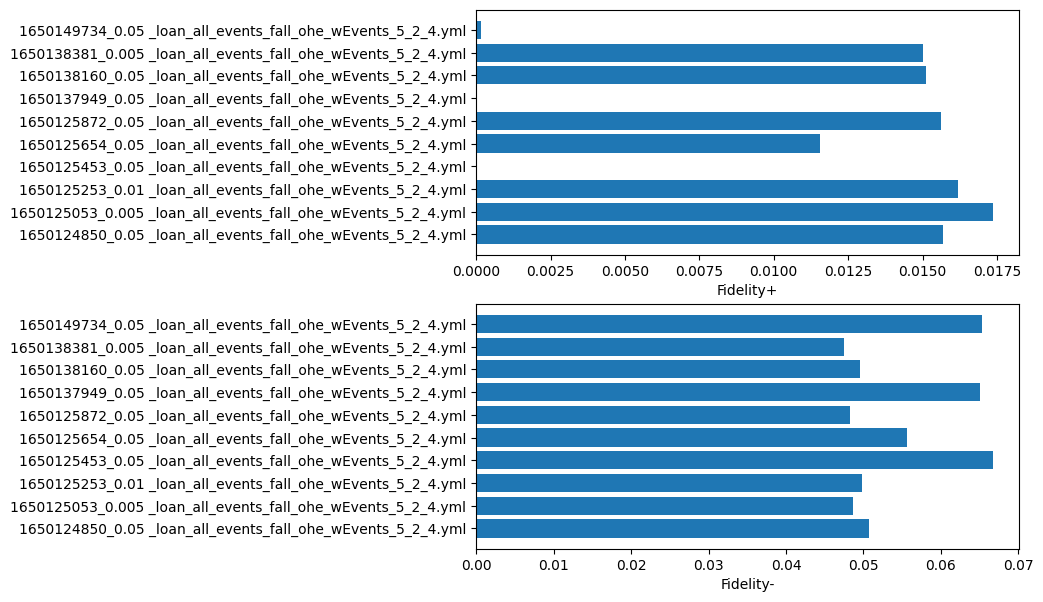

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

#### Länge 7

In [ ]:
# Dataset und Model
key = 7
dataset7 = dataset[key]
input_dim = dataset7[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset7)

In [ ]:
print(path)

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 154.04it/s]


Epoch: 0 | Loss: 3235.5839543640614


100%|██████████| 5000/5000 [00:32<00:00, 153.97it/s]


Epoch: 1 | Loss: 3233.6331891715527


100%|██████████| 5000/5000 [00:32<00:00, 154.19it/s]


Epoch: 2 | Loss: 3212.1656301617622


100%|██████████| 5000/5000 [00:32<00:00, 154.14it/s]


Epoch: 3 | Loss: 3177.705706715584


100%|██████████| 5000/5000 [00:32<00:00, 153.84it/s]


Epoch: 4 | Loss: 3147.075460612774
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 68.75it/s]


Fidelity+: 0.06680754572153091, Fidelity-: 0.02623475156724453, Sparsity: 0.5457143783569336
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 154.27it/s]


Epoch: 0 | Loss: 3235.355037301779


100%|██████████| 5000/5000 [00:32<00:00, 154.57it/s]


Epoch: 1 | Loss: 3233.99794664979


100%|██████████| 5000/5000 [00:32<00:00, 154.04it/s]


Epoch: 2 | Loss: 3232.743792027235


100%|██████████| 5000/5000 [00:32<00:00, 153.90it/s]


Epoch: 3 | Loss: 3229.5856023430824


100%|██████████| 5000/5000 [00:32<00:00, 154.89it/s]


Epoch: 4 | Loss: 3225.7601239979267
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 69.56it/s]


Fidelity+: 0.06723519414663315, Fidelity-: 0.02591913565993309, Sparsity: 0.5500000715255737
save Hyperparameter


In [ ]:
param = {
    "lr": 0.001,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.001--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 155.04it/s]


Epoch: 0 | Loss: 3235.4935775995255


100%|██████████| 5000/5000 [00:32<00:00, 155.60it/s]


Epoch: 1 | Loss: 3236.0887748897076


100%|██████████| 5000/5000 [00:32<00:00, 155.34it/s]


Epoch: 2 | Loss: 3235.6589229106903


100%|██████████| 5000/5000 [00:32<00:00, 156.04it/s]


Epoch: 3 | Loss: 3234.8339974582195


100%|██████████| 5000/5000 [00:32<00:00, 154.71it/s]


Epoch: 4 | Loss: 3236.8952893316746
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 69.30it/s]


Fidelity+: 0.06670143455266953, Fidelity-: 0.026493988931179047, Sparsity: 0.5428571701049805
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 153.07it/s]


Epoch: 0 | Loss: 3099.955631583929


100%|██████████| 5000/5000 [00:32<00:00, 154.64it/s]


Epoch: 1 | Loss: 3044.3642233908176


100%|██████████| 5000/5000 [00:32<00:00, 154.42it/s]


Epoch: 2 | Loss: 2977.6386052668095


100%|██████████| 5000/5000 [00:32<00:00, 153.99it/s]


Epoch: 3 | Loss: 2967.5837647914886


100%|██████████| 5000/5000 [00:32<00:00, 154.20it/s]


Epoch: 4 | Loss: 2967.5077052116394
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:15<00:00, 65.85it/s]


Fidelity+: 5.364417798858767e-10, Fidelity-: 0.09479271620512009, Sparsity: 1.0
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 4.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:36<00:00, 138.41it/s]


Epoch: 0 | Loss: 3091.2571123838425


100%|██████████| 5000/5000 [00:33<00:00, 150.92it/s]


Epoch: 1 | Loss: 3013.6709747314453


100%|██████████| 5000/5000 [00:33<00:00, 151.43it/s]


Epoch: 2 | Loss: 2961.841664671898


100%|██████████| 5000/5000 [00:33<00:00, 150.46it/s]


Epoch: 3 | Loss: 2958.6995592415333


100%|██████████| 5000/5000 [00:33<00:00, 151.36it/s]


Epoch: 4 | Loss: 2958.6784158349037
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 68.02it/s]


Fidelity+: 0.0, Fidelity-: 0.09663435816764832, Sparsity: 1.0
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 3.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:33<00:00, 150.84it/s]


Epoch: 0 | Loss: 3093.31879350543


100%|██████████| 5000/5000 [00:33<00:00, 150.90it/s]


Epoch: 1 | Loss: 3002.802227318287


100%|██████████| 5000/5000 [00:33<00:00, 151.48it/s]


Epoch: 2 | Loss: 2960.3299066722393


100%|██████████| 5000/5000 [00:32<00:00, 151.54it/s]


Epoch: 3 | Loss: 2958.686759799719


100%|██████████| 5000/5000 [00:32<00:00, 152.04it/s]


Epoch: 4 | Loss: 2958.678388953209
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 67.55it/s]


Fidelity+: 0.0, Fidelity-: 0.09663435071706772, Sparsity: 1.0
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 2.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 152.43it/s]


Epoch: 0 | Loss: 3095.479144603014


100%|██████████| 5000/5000 [00:32<00:00, 151.68it/s]


Epoch: 1 | Loss: 2986.8697614073753


100%|██████████| 5000/5000 [00:32<00:00, 152.67it/s]


Epoch: 2 | Loss: 2959.2342004179955


100%|██████████| 5000/5000 [00:32<00:00, 152.90it/s]


Epoch: 3 | Loss: 2958.6803756654263


100%|██████████| 5000/5000 [00:33<00:00, 151.47it/s]


Epoch: 4 | Loss: 2958.6783860623837
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 68.18it/s]


Fidelity+: -3.576278717609682e-10, Fidelity-: 0.09663435071706772, Sparsity: 1.0
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 155.65it/s]


Epoch: 0 | Loss: 3236.02806481719


100%|██████████| 5000/5000 [00:32<00:00, 155.36it/s]


Epoch: 1 | Loss: 3229.577429562807


100%|██████████| 5000/5000 [00:32<00:00, 155.12it/s]


Epoch: 2 | Loss: 3206.638987094164


100%|██████████| 5000/5000 [00:32<00:00, 153.53it/s]


Epoch: 3 | Loss: 3172.7459543943405


100%|██████████| 5000/5000 [00:34<00:00, 146.95it/s]


Epoch: 4 | Loss: 3143.266599059105
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:15<00:00, 63.18it/s]


Fidelity+: 0.06626816838979721, Fidelity-: 0.0268251970410347, Sparsity: 0.5429999828338623
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 500/500 [00:03<00:00, 152.66it/s]


Epoch: 0 | Loss: 322.87058687210083


100%|██████████| 500/500 [00:03<00:00, 150.95it/s]


Epoch: 1 | Loss: 322.2580074071884


100%|██████████| 500/500 [00:03<00:00, 155.47it/s]


Epoch: 2 | Loss: 320.0261495113373


100%|██████████| 500/500 [00:03<00:00, 154.89it/s]


Epoch: 3 | Loss: 316.92176792025566


100%|██████████| 500/500 [00:03<00:00, 152.99it/s]


Epoch: 4 | Loss: 313.7175956964493
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 68.95it/s]


Fidelity+: 0.0631333589553833, Fidelity-: 0.02900650165975094, Sparsity: 0.5400000214576721
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:31<00:00, 158.73it/s]


Epoch: 0 | Loss: 3153.035618841648


100%|██████████| 5000/5000 [00:32<00:00, 154.12it/s]


Epoch: 1 | Loss: 3117.3959686160088


100%|██████████| 5000/5000 [00:37<00:00, 134.52it/s]


Epoch: 2 | Loss: 3081.1758650541306


100%|██████████| 5000/5000 [00:30<00:00, 162.47it/s]


Epoch: 3 | Loss: 3078.160433769226


100%|██████████| 5000/5000 [00:31<00:00, 160.82it/s]


Epoch: 4 | Loss: 3078.147370696068
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 70.87it/s]


Fidelity+: -2.3841859042583735e-10, Fidelity-: 0.09308214485645294, Sparsity: 1.0
save Hyperparameter


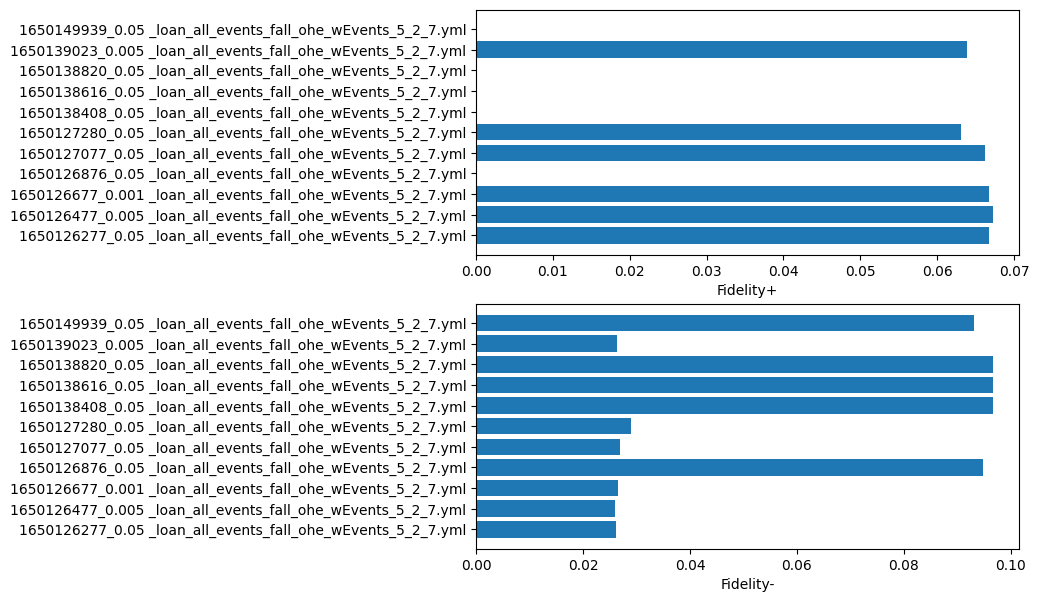

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

#### Länge 10

In [ ]:
# Dataset und Model
key = 10
dataset10 = dataset[key]
input_dim = dataset10[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset10)

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 153.60it/s]


Epoch: 0 | Loss: 3201.981152445078


100%|██████████| 5000/5000 [00:32<00:00, 153.19it/s]


Epoch: 1 | Loss: 3194.63522452116


100%|██████████| 5000/5000 [00:32<00:00, 153.14it/s]


Epoch: 2 | Loss: 3132.0106373131275


100%|██████████| 5000/5000 [00:32<00:00, 153.72it/s]


Epoch: 3 | Loss: 3088.6083953380585


100%|██████████| 5000/5000 [00:32<00:00, 152.89it/s]


Epoch: 4 | Loss: 3036.9338133633137
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 68.92it/s]


Fidelity+: 0.10980668663978577, Fidelity-: 0.03648316487669945, Sparsity: 0.45500004291534424
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 154.21it/s]


Epoch: 0 | Loss: 3202.1275793910027


100%|██████████| 5000/5000 [00:32<00:00, 153.60it/s]


Epoch: 1 | Loss: 3199.532105833292


100%|██████████| 5000/5000 [00:32<00:00, 154.16it/s]


Epoch: 2 | Loss: 3193.3905726373196


100%|██████████| 5000/5000 [00:32<00:00, 153.01it/s]


Epoch: 3 | Loss: 3184.6042543649673


100%|██████████| 5000/5000 [00:32<00:00, 153.75it/s]


Epoch: 4 | Loss: 3170.4773830473423
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 68.59it/s]


Fidelity+: 0.10742158442735672, Fidelity-: 0.039234597235918045, Sparsity: 0.45350003242492676
save Hyperparameter


In [ ]:
param = {
    "lr": 0.01,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.01--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 154.12it/s]


Epoch: 0 | Loss: 3202.4444309473038


100%|██████████| 5000/5000 [00:32<00:00, 154.66it/s]


Epoch: 1 | Loss: 3193.249935030937


100%|██████████| 5000/5000 [00:32<00:00, 153.59it/s]


Epoch: 2 | Loss: 3177.6967271864414


100%|██████████| 5000/5000 [00:32<00:00, 154.18it/s]


Epoch: 3 | Loss: 3151.3228799402714


100%|██████████| 5000/5000 [00:32<00:00, 154.50it/s]


Epoch: 4 | Loss: 3123.5357913672924
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 67.99it/s]


Fidelity+: 0.10720078647136688, Fidelity-: 0.03947199508547783, Sparsity: 0.45430004596710205
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 153.72it/s]


Epoch: 0 | Loss: 2999.1683663129807


100%|██████████| 5000/5000 [00:32<00:00, 153.72it/s]


Epoch: 1 | Loss: 2895.2161096930504


100%|██████████| 5000/5000 [00:32<00:00, 153.78it/s]


Epoch: 2 | Loss: 2803.731836825609


100%|██████████| 5000/5000 [00:32<00:00, 152.97it/s]


Epoch: 3 | Loss: 2796.1429968476295


100%|██████████| 5000/5000 [00:32<00:00, 153.53it/s]


Epoch: 4 | Loss: 2796.078690379858
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 68.82it/s]


Fidelity+: -5.364417798858767e-10, Fidelity-: 0.15684451162815094, Sparsity: 1.0
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 153.59it/s]


Epoch: 0 | Loss: 3202.7108596265316


100%|██████████| 5000/5000 [00:33<00:00, 147.18it/s]


Epoch: 1 | Loss: 3188.7799969911575


100%|██████████| 5000/5000 [00:34<00:00, 143.14it/s]


Epoch: 2 | Loss: 3136.6941052377224


100%|██████████| 5000/5000 [00:32<00:00, 154.54it/s]


Epoch: 3 | Loss: 3079.571395277977


100%|██████████| 5000/5000 [00:32<00:00, 152.97it/s]


Epoch: 4 | Loss: 3027.54139149189
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 68.74it/s]


Fidelity+: 0.10961302369832993, Fidelity-: 0.03658924251794815, Sparsity: 0.45500001311302185
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 500/500 [00:03<00:00, 154.21it/s]


Epoch: 0 | Loss: 322.1058968901634


100%|██████████| 500/500 [00:03<00:00, 154.36it/s]


Epoch: 1 | Loss: 320.0532100200653


100%|██████████| 500/500 [00:03<00:00, 154.83it/s]


Epoch: 2 | Loss: 312.86776727437973


100%|██████████| 500/500 [00:03<00:00, 149.64it/s]


Epoch: 3 | Loss: 307.5221717953682


100%|██████████| 500/500 [00:03<00:00, 154.45it/s]


Epoch: 4 | Loss: 303.3091396391392
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 68.80it/s]

Fidelity+: 0.07436629384756088, Fidelity-: 0.060020796954631805, Sparsity: 0.5714000463485718
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.005--------------------------


100%|██████████| 500/500 [00:03<00:00, 152.60it/s]


Epoch: 0 | Loss: 323.6095498204231


100%|██████████| 500/500 [00:03<00:00, 152.51it/s]


Epoch: 1 | Loss: 323.54083544015884


100%|██████████| 500/500 [00:03<00:00, 151.33it/s]


Epoch: 2 | Loss: 323.3388107120991


100%|██████████| 500/500 [00:03<00:00, 152.71it/s]


Epoch: 3 | Loss: 322.891653239727


100%|██████████| 500/500 [00:03<00:00, 152.11it/s]


Epoch: 4 | Loss: 322.58779031038284
PGExplainer Anwenden


100%|██████████| 500/500 [00:08<00:00, 60.29it/s]


Fidelity+: 0.06392594426870346, Fidelity-: 0.026335373520851135, Sparsity: 0.5479999780654907
save Hyperparameter


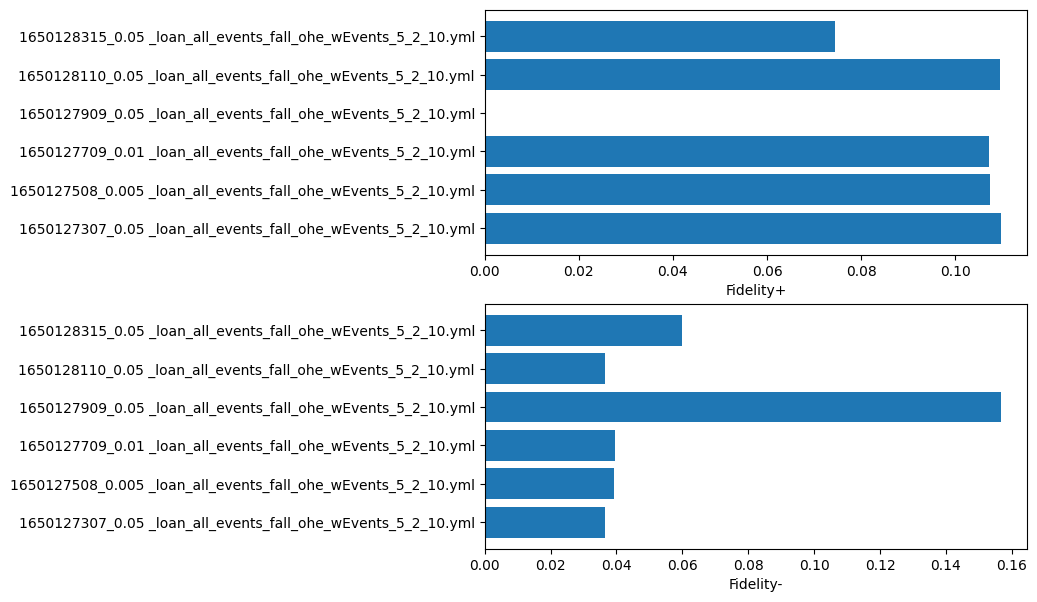

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

####Länge 13

In [ ]:
# Dataset und Model
key = 13
dataset13 = dataset[key]
input_dim = dataset13[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset13)

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 153.23it/s]


Epoch: 0 | Loss: 3299.038535166532


100%|██████████| 5000/5000 [00:32<00:00, 153.64it/s]


Epoch: 1 | Loss: 3194.6774829998612


100%|██████████| 5000/5000 [00:32<00:00, 152.10it/s]


Epoch: 2 | Loss: 2999.6391376182437


100%|██████████| 5000/5000 [00:32<00:00, 153.24it/s]


Epoch: 3 | Loss: 2924.5651797503233


100%|██████████| 5000/5000 [00:32<00:00, 153.25it/s]


Epoch: 4 | Loss: 2827.328363902867
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:15<00:00, 64.53it/s]


Fidelity+: 0.2896190881729126, Fidelity-: 0.058375146239995956, Sparsity: 0.5016922950744629
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 153.18it/s]


Epoch: 0 | Loss: 3303.0553107485175


100%|██████████| 5000/5000 [00:32<00:00, 153.21it/s]


Epoch: 1 | Loss: 3295.867273043841


100%|██████████| 5000/5000 [00:32<00:00, 153.78it/s]


Epoch: 2 | Loss: 3277.435241982341


100%|██████████| 5000/5000 [00:32<00:00, 153.62it/s]


Epoch: 3 | Loss: 3257.014212206006


100%|██████████| 5000/5000 [00:32<00:00, 153.04it/s]


Epoch: 4 | Loss: 3220.2807434648275
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 69.18it/s]


Fidelity+: 0.292283296585083, Fidelity-: 0.055166009813547134, Sparsity: 0.4994615912437439
save Hyperparameter


In [ ]:
param = {
    "lr": 0.01,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.01--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 154.46it/s]


Epoch: 0 | Loss: 3303.021060463041


100%|██████████| 5000/5000 [00:32<00:00, 154.95it/s]


Epoch: 1 | Loss: 3282.1025686636567


100%|██████████| 5000/5000 [00:32<00:00, 154.48it/s]


Epoch: 2 | Loss: 3245.942858926952


100%|██████████| 5000/5000 [00:32<00:00, 154.60it/s]


Epoch: 3 | Loss: 3191.1003363654017


100%|██████████| 5000/5000 [00:32<00:00, 155.00it/s]


Epoch: 4 | Loss: 3105.441383741796
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 68.40it/s]


Fidelity+: 0.2914252281188965, Fidelity-: 0.05690564587712288, Sparsity: 0.5013077259063721
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 154.45it/s]


Epoch: 0 | Loss: 3028.7289056708105


100%|██████████| 5000/5000 [00:32<00:00, 153.98it/s]


Epoch: 1 | Loss: 2858.465309921652


100%|██████████| 5000/5000 [00:32<00:00, 154.86it/s]


Epoch: 2 | Loss: 2621.5499596111476


100%|██████████| 5000/5000 [00:32<00:00, 154.79it/s]


Epoch: 3 | Loss: 2594.0635748980567


100%|██████████| 5000/5000 [00:32<00:00, 153.96it/s]


Epoch: 4 | Loss: 2599.1792383873835
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 69.80it/s]


Fidelity+: 0.007848458364605904, Fidelity-: 0.29029521346092224, Sparsity: 0.9116923213005066
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model,ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 154.61it/s]


Epoch: 0 | Loss: 3302.315245870501


100%|██████████| 5000/5000 [00:32<00:00, 155.36it/s]


Epoch: 1 | Loss: 3245.6316974684596


100%|██████████| 5000/5000 [00:32<00:00, 154.71it/s]


Epoch: 2 | Loss: 3055.8998333886266


100%|██████████| 5000/5000 [00:32<00:00, 154.29it/s]


Epoch: 3 | Loss: 2894.3177002370358


100%|██████████| 5000/5000 [00:32<00:00, 154.56it/s]


Epoch: 4 | Loss: 2799.375377766788
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 68.66it/s]


Fidelity+: 0.2908579409122467, Fidelity-: 0.05768426135182381, Sparsity: 0.49992311000823975
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 500/500 [00:03<00:00, 153.97it/s]


Epoch: 0 | Loss: 328.78580462932587


100%|██████████| 500/500 [00:03<00:00, 153.57it/s]


Epoch: 1 | Loss: 317.1036744713783


100%|██████████| 500/500 [00:03<00:00, 152.85it/s]


Epoch: 2 | Loss: 298.8821157515049


100%|██████████| 500/500 [00:03<00:00, 155.18it/s]


Epoch: 3 | Loss: 291.32082119584084


100%|██████████| 500/500 [00:03<00:00, 155.98it/s]


Epoch: 4 | Loss: 280.35567627847195
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 68.67it/s]


Fidelity+: 0.21093343198299408, Fidelity-: 0.12064231932163239, Sparsity: 0.6741538047790527
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.005--------------------------


100%|██████████| 500/500 [00:03<00:00, 150.97it/s]


Epoch: 0 | Loss: 332.46929420158267


100%|██████████| 500/500 [00:03<00:00, 150.28it/s]


Epoch: 1 | Loss: 331.03865941241384


100%|██████████| 500/500 [00:03<00:00, 150.88it/s]


Epoch: 2 | Loss: 329.00524739921093


100%|██████████| 500/500 [00:03<00:00, 150.88it/s]


Epoch: 3 | Loss: 325.1170038729906


100%|██████████| 500/500 [00:03<00:00, 151.64it/s]


Epoch: 4 | Loss: 320.03366930037737
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 67.97it/s]


Fidelity+: 0.21100741624832153, Fidelity-: 0.1163325384259224, Sparsity: 0.66969233751297
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.005--------------------------


100%|██████████| 500/500 [00:03<00:00, 151.54it/s]


Epoch: 0 | Loss: 305.53897057054564


100%|██████████| 500/500 [00:03<00:00, 153.22it/s]


Epoch: 1 | Loss: 304.45161147695035


100%|██████████| 500/500 [00:03<00:00, 152.26it/s]


Epoch: 2 | Loss: 302.98880031332374


100%|██████████| 500/500 [00:03<00:00, 153.66it/s]


Epoch: 3 | Loss: 299.7064981814474


100%|██████████| 500/500 [00:03<00:00, 152.26it/s]


Epoch: 4 | Loss: 292.0770221725106
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 67.57it/s]


Fidelity+: 0.20700648427009583, Fidelity-: 0.12660124897956848, Sparsity: 0.6687692403793335
save Hyperparameter


In [ ]:
param = {
    "lr": 0.0001,
    "sparsity_ziel": 0.7,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.0001--------------------------


100%|██████████| 500/500 [00:03<00:00, 158.45it/s]


Epoch: 0 | Loss: 302.4416234642267


100%|██████████| 500/500 [00:03<00:00, 157.74it/s]


Epoch: 1 | Loss: 302.2813599854708


100%|██████████| 500/500 [00:03<00:00, 158.88it/s]


Epoch: 2 | Loss: 300.6215987056494


100%|██████████| 500/500 [00:03<00:00, 159.36it/s]


Epoch: 3 | Loss: 299.46704322099686


100%|██████████| 500/500 [00:03<00:00, 157.18it/s]


Epoch: 4 | Loss: 301.003635391593
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 70.93it/s]


Fidelity+: 0.19571368396282196, Fidelity-: 0.1564004272222519, Sparsity: 0.6641538143157959
save Hyperparameter


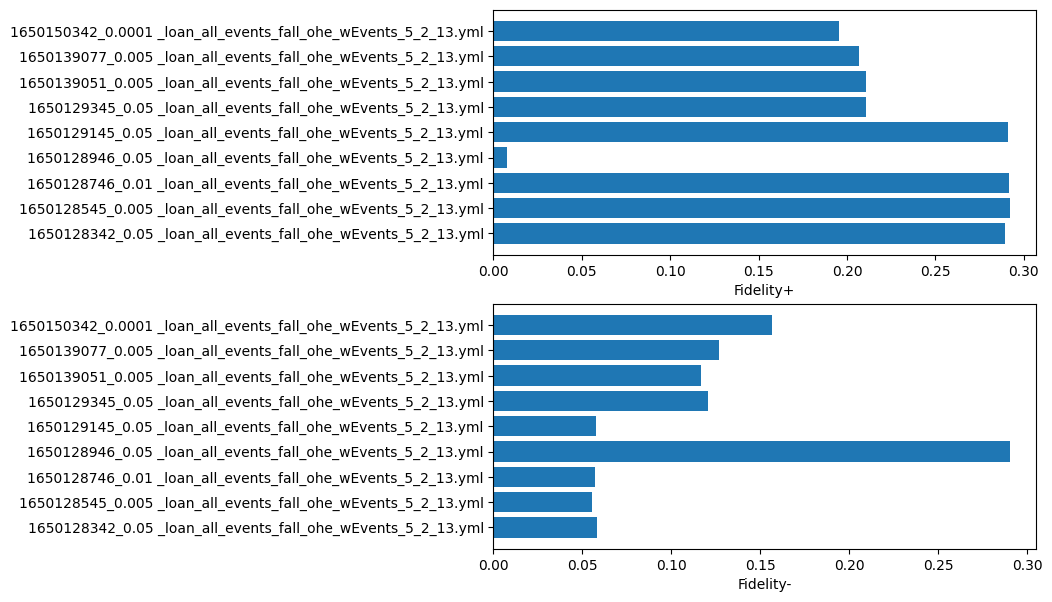

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

####Länge 16

In [ ]:
# Dataset und Model
key = 16
dataset16 = dataset[key]
input_dim = dataset16[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset16)

In [ ]:
print(path)

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 16075/16075 [01:44<00:00, 154.10it/s]


Epoch: 0 | Loss: 9534.953999504447


100%|██████████| 16075/16075 [01:44<00:00, 153.73it/s]


Epoch: 1 | Loss: 9312.777260303497


100%|██████████| 16075/16075 [01:45<00:00, 152.93it/s]


Epoch: 2 | Loss: 8873.18113423884


100%|██████████| 16075/16075 [01:44<00:00, 153.85it/s]


Epoch: 3 | Loss: 8553.087091967463


100%|██████████| 16075/16075 [01:44<00:00, 153.75it/s]


Epoch: 4 | Loss: 8211.231568425894
PGExplainer Anwenden


100%|██████████| 4019/4019 [00:58<00:00, 68.43it/s]


Fidelity+: 0.24200765788555145, Fidelity-: 0.04518737271428108, Sparsity: 0.5010108351707458
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.0001, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 16075/16075 [01:46<00:00, 151.51it/s]


Epoch: 0 | Loss: 8322.411851264536


100%|██████████| 16075/16075 [01:46<00:00, 150.94it/s]


Epoch: 1 | Loss: 7517.376272090711


100%|██████████| 16075/16075 [01:46<00:00, 151.38it/s]


Epoch: 2 | Loss: 7052.3065496739


100%|██████████| 16075/16075 [01:47<00:00, 150.02it/s]


Epoch: 3 | Loss: 7033.740316956304


100%|██████████| 16075/16075 [01:48<00:00, 148.01it/s]


Epoch: 4 | Loss: 7033.588855707087
PGExplainer Anwenden


100%|██████████| 4019/4019 [00:58<00:00, 68.77it/s]


Fidelity+: 6.226229743333533e-05, Fidelity-: 0.2991640865802765, Sparsity: 0.9993624091148376
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 16075/16075 [01:43<00:00, 154.84it/s]


Epoch: 0 | Loss: 9540.797556340694


100%|██████████| 16075/16075 [01:44<00:00, 154.14it/s]


Epoch: 1 | Loss: 9514.939100041986


100%|██████████| 16075/16075 [01:44<00:00, 154.25it/s]


Epoch: 2 | Loss: 9467.20181941986


100%|██████████| 16075/16075 [01:44<00:00, 154.38it/s]


Epoch: 3 | Loss: 9396.720635771751


100%|██████████| 16075/16075 [01:44<00:00, 154.18it/s]


Epoch: 4 | Loss: 9292.708016678691
PGExplainer Anwenden


100%|██████████| 4019/4019 [00:57<00:00, 70.39it/s]


Fidelity+: 0.23846003413200378, Fidelity-: 0.04628937691450119, Sparsity: 0.5008242130279541
save Hyperparameter


In [ ]:
param = {
    "lr": 0.01,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.01--------------------------


100%|██████████| 16075/16075 [01:44<00:00, 153.99it/s]


Epoch: 0 | Loss: 9538.57815092802


100%|██████████| 16075/16075 [01:45<00:00, 152.83it/s]


Epoch: 1 | Loss: 9494.242893904448


100%|██████████| 16075/16075 [01:44<00:00, 153.20it/s]


Epoch: 2 | Loss: 9397.333271950483


100%|██████████| 16075/16075 [01:44<00:00, 153.42it/s]


Epoch: 3 | Loss: 9240.020607173443


100%|██████████| 16075/16075 [01:44<00:00, 153.17it/s]


Epoch: 4 | Loss: 9037.39132784307
PGExplainer Anwenden


100%|██████████| 4019/4019 [00:59<00:00, 67.80it/s]


Fidelity+: 0.23698537051677704, Fidelity-: 0.04757562652230263, Sparsity: 0.5010263919830322
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 16075/16075 [01:44<00:00, 153.92it/s]


Epoch: 0 | Loss: 8463.948064215481


100%|██████████| 16075/16075 [01:45<00:00, 153.01it/s]


Epoch: 1 | Loss: 7896.573545619845


100%|██████████| 16075/16075 [01:45<00:00, 152.71it/s]


Epoch: 2 | Loss: 7308.546324778348


100%|██████████| 16075/16075 [01:45<00:00, 152.27it/s]


Epoch: 3 | Loss: 7267.145981799811


100%|██████████| 16075/16075 [01:44<00:00, 153.84it/s]


Epoch: 4 | Loss: 7267.455756161362
PGExplainer Anwenden


100%|██████████| 4019/4019 [00:57<00:00, 70.03it/s]


Fidelity+: 0.0002443279081489891, Fidelity-: 0.30197873711586, Sparsity: 0.9979627728462219
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 16075/16075 [01:45<00:00, 152.54it/s]


Epoch: 0 | Loss: 9541.475505203009


100%|██████████| 16075/16075 [01:45<00:00, 152.62it/s]


Epoch: 1 | Loss: 9427.196763724089


100%|██████████| 16075/16075 [01:45<00:00, 152.65it/s]


Epoch: 2 | Loss: 9056.593324184418


100%|██████████| 16075/16075 [01:45<00:00, 152.66it/s]


Epoch: 3 | Loss: 8767.090063005686


100%|██████████| 16075/16075 [01:44<00:00, 153.13it/s]


Epoch: 4 | Loss: 8360.196523725986
PGExplainer Anwenden


100%|██████████| 4019/4019 [00:59<00:00, 67.96it/s]


Fidelity+: 0.2394465208053589, Fidelity-: 0.04691081494092941, Sparsity: 0.502223789691925
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 500/500 [00:03<00:00, 153.09it/s]


Epoch: 0 | Loss: 298.9090257883072


100%|██████████| 500/500 [00:03<00:00, 153.74it/s]


Epoch: 1 | Loss: 291.04220873117447


100%|██████████| 500/500 [00:03<00:00, 152.67it/s]


Epoch: 2 | Loss: 275.5866238772869


100%|██████████| 500/500 [00:03<00:00, 155.36it/s]


Epoch: 3 | Loss: 263.3095764219761


100%|██████████| 500/500 [00:03<00:00, 156.73it/s]


Epoch: 4 | Loss: 253.64482137560844
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 69.14it/s]


Fidelity+: 0.19515039026737213, Fidelity-: 0.07845176756381989, Sparsity: 0.6358749866485596
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 16075/16075 [01:40<00:00, 159.72it/s]


Epoch: 0 | Loss: 8941.769029058516


100%|██████████| 16075/16075 [01:40<00:00, 160.29it/s]


Epoch: 1 | Loss: 8644.626076556742


100%|██████████| 16075/16075 [01:40<00:00, 160.21it/s]


Epoch: 2 | Loss: 8211.47033817321


100%|██████████| 16075/16075 [01:41<00:00, 158.16it/s]


Epoch: 3 | Loss: 8212.19787362963


100%|██████████| 16075/16075 [01:47<00:00, 149.28it/s]


Epoch: 4 | Loss: 8229.336139842868
PGExplainer Anwenden


100%|██████████| 4019/4019 [00:56<00:00, 71.38it/s]


Fidelity+: 0.014017454348504543, Fidelity-: 0.29231587052345276, Sparsity: 0.9036296606063843
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.05, 
    "coff_ent": 0.00005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 16075/16075 [01:40<00:00, 159.26it/s]


Epoch: 0 | Loss: 14375.316513717175


100%|██████████| 16075/16075 [01:40<00:00, 159.58it/s]


Epoch: 1 | Loss: 12450.529284745455


100%|██████████| 16075/16075 [01:40<00:00, 159.99it/s]


Epoch: 2 | Loss: 9753.841242164373


100%|██████████| 16075/16075 [01:41<00:00, 158.94it/s]


Epoch: 3 | Loss: 9101.415496900678


100%|██████████| 16075/16075 [01:40<00:00, 159.25it/s]


Epoch: 4 | Loss: 9089.492832660675
PGExplainer Anwenden


100%|██████████| 4019/4019 [00:57<00:00, 70.47it/s]


Fidelity+: 0.06723063439130783, Fidelity-: 0.20625939965248108, Sparsity: 0.5043076872825623
save Hyperparameter


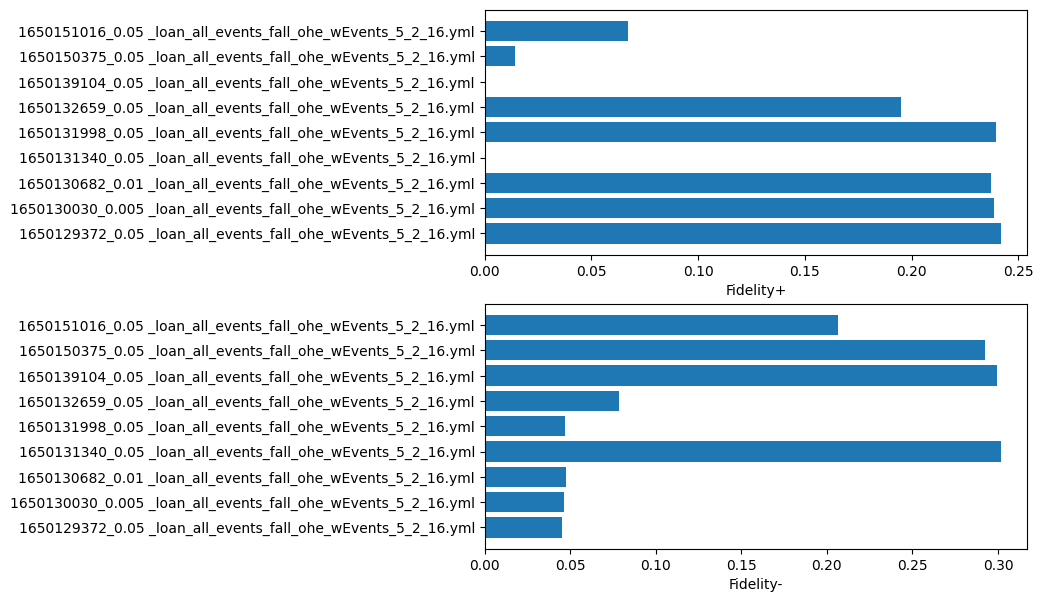

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

####Länge 19

In [ ]:
# Dataset und Model
key = 19
dataset19 = dataset[key]
input_dim = dataset19[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset19)

In [ ]:
print(path)

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 13760/13760 [01:29<00:00, 153.51it/s]


Epoch: 0 | Loss: 8774.79410225153


100%|██████████| 13760/13760 [01:29<00:00, 154.20it/s]


Epoch: 1 | Loss: 8479.731245189905


100%|██████████| 13760/13760 [01:29<00:00, 154.07it/s]


Epoch: 2 | Loss: 8281.252772212029


100%|██████████| 13760/13760 [01:29<00:00, 153.62it/s]


Epoch: 3 | Loss: 8171.812961250544


100%|██████████| 13760/13760 [01:29<00:00, 153.81it/s]


Epoch: 4 | Loss: 7980.194146901369
PGExplainer Anwenden


100%|██████████| 3440/3440 [00:50<00:00, 68.67it/s]


Fidelity+: 0.1639268547296524, Fidelity-: 0.08207103610038757, Sparsity: 0.5959454774856567
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 13760/13760 [01:29<00:00, 154.59it/s]


Epoch: 0 | Loss: 8780.102073132992


100%|██████████| 13760/13760 [01:29<00:00, 154.19it/s]


Epoch: 1 | Loss: 8754.210092037916


100%|██████████| 13760/13760 [01:29<00:00, 154.53it/s]


Epoch: 2 | Loss: 8712.176234275103


100%|██████████| 13760/13760 [01:29<00:00, 154.46it/s]


Epoch: 3 | Loss: 8642.591636151075


100%|██████████| 13760/13760 [01:29<00:00, 154.13it/s]


Epoch: 4 | Loss: 8547.554625988007
PGExplainer Anwenden


100%|██████████| 3440/3440 [00:49<00:00, 69.31it/s]


Fidelity+: 0.19145531952381134, Fidelity-: 0.04052899777889252, Sparsity: 0.5339810252189636
save Hyperparameter


In [ ]:
param = {
    "lr": 0.01,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.01--------------------------


100%|██████████| 13760/13760 [01:29<00:00, 154.27it/s]


Epoch: 0 | Loss: 8780.657132863998


100%|██████████| 13760/13760 [01:29<00:00, 154.49it/s]


Epoch: 1 | Loss: 8726.204760104418


100%|██████████| 13760/13760 [01:28<00:00, 154.76it/s]


Epoch: 2 | Loss: 8623.872509986162


100%|██████████| 13760/13760 [01:28<00:00, 154.78it/s]


Epoch: 3 | Loss: 8471.604501485825


100%|██████████| 13760/13760 [01:28<00:00, 154.64it/s]


Epoch: 4 | Loss: 8319.764715135098
PGExplainer Anwenden


100%|██████████| 3440/3440 [00:50<00:00, 68.47it/s]


Fidelity+: 0.18955054879188538, Fidelity-: 0.04198837652802467, Sparsity: 0.534042239189148
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 13760/13760 [01:29<00:00, 154.42it/s]


Epoch: 0 | Loss: 7681.756660059094


100%|██████████| 13760/13760 [01:28<00:00, 154.66it/s]


Epoch: 1 | Loss: 7237.6115904301405


100%|██████████| 13760/13760 [01:29<00:00, 154.35it/s]


Epoch: 2 | Loss: 6522.458168461919


100%|██████████| 13760/13760 [01:28<00:00, 154.61it/s]


Epoch: 3 | Loss: 6434.6867841258645


100%|██████████| 13760/13760 [01:29<00:00, 154.51it/s]


Epoch: 4 | Loss: 6437.1740996316075
PGExplainer Anwenden


100%|██████████| 3440/3440 [00:49<00:00, 69.55it/s]


Fidelity+: 0.0011599655263125896, Fidelity-: 0.26021215319633484, Sparsity: 0.9802937507629395
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 13760/13760 [01:29<00:00, 153.55it/s]


Epoch: 0 | Loss: 8782.766138732433


100%|██████████| 13760/13760 [01:29<00:00, 153.32it/s]


Epoch: 1 | Loss: 8692.5494633317


100%|██████████| 13760/13760 [01:29<00:00, 153.24it/s]


Epoch: 2 | Loss: 8353.099914342165


100%|██████████| 13760/13760 [01:29<00:00, 153.36it/s]


Epoch: 3 | Loss: 8179.2789605259895


100%|██████████| 13760/13760 [01:30<00:00, 151.83it/s]


Epoch: 4 | Loss: 7999.582556068897
PGExplainer Anwenden


100%|██████████| 3440/3440 [00:51<00:00, 66.90it/s]


Fidelity+: 0.17791740596294403, Fidelity-: 0.06264591217041016, Sparsity: 0.5658047795295715
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 500/500 [00:03<00:00, 152.82it/s]


Epoch: 0 | Loss: 316.8822115659714


100%|██████████| 500/500 [00:03<00:00, 153.04it/s]


Epoch: 1 | Loss: 309.66912576556206


100%|██████████| 500/500 [00:03<00:00, 154.39it/s]


Epoch: 2 | Loss: 297.706395059824


100%|██████████| 500/500 [00:03<00:00, 154.67it/s]


Epoch: 3 | Loss: 294.31114649772644


100%|██████████| 500/500 [00:03<00:00, 155.65it/s]


Epoch: 4 | Loss: 288.4089601933956
PGExplainer Anwenden


100%|██████████| 500/500 [00:07<00:00, 68.63it/s]


Fidelity+: 0.10330196470022202, Fidelity-: 0.15470023453235626, Sparsity: 0.7548421025276184
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 13760/13760 [01:26<00:00, 159.08it/s]


Epoch: 0 | Loss: 8165.520280390978


100%|██████████| 13760/13760 [01:29<00:00, 154.19it/s]


Epoch: 1 | Loss: 8112.633600205183


100%|██████████| 13760/13760 [01:26<00:00, 159.04it/s]


Epoch: 2 | Loss: 8036.10516539216


100%|██████████| 13760/13760 [01:26<00:00, 159.65it/s]


Epoch: 3 | Loss: 7920.950345620513


100%|██████████| 13760/13760 [01:26<00:00, 158.22it/s]


Epoch: 4 | Loss: 7766.487091973424
PGExplainer Anwenden


100%|██████████| 3440/3440 [00:48<00:00, 70.22it/s]


Fidelity+: 0.18490774929523468, Fidelity-: 0.044835127890110016, Sparsity: 0.5316707491874695
save Hyperparameter


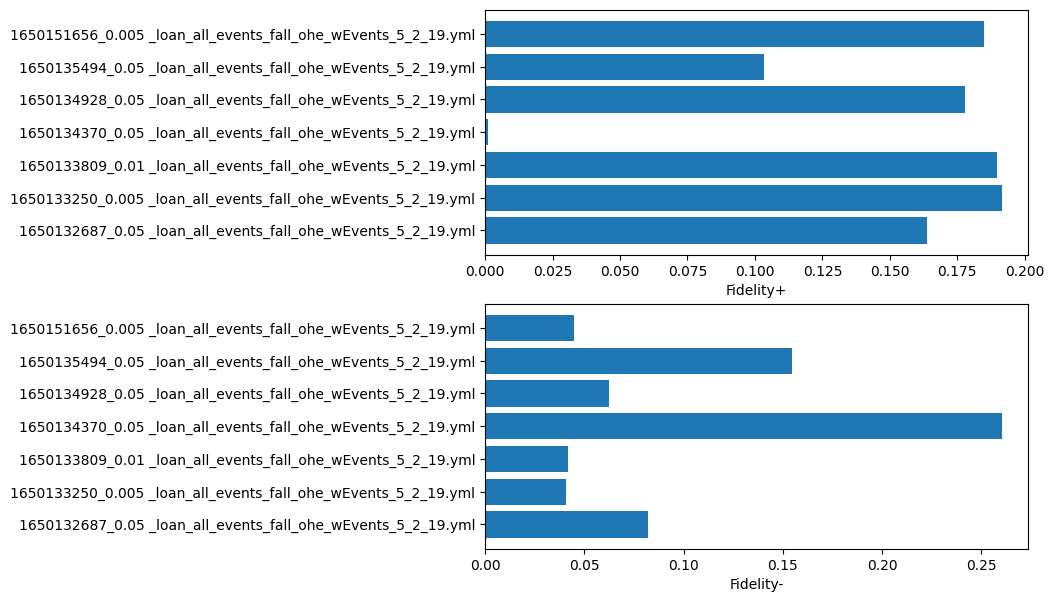

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

##Trainieren

###Aktivitäten basiert

In [ ]:
dataset_name


'loan_sn_f2_ohe_wEvents_4_nreb'

In [ ]:
model = load_gcn(dataset_name, input_dim, device, path)

In [ ]:
param = {
    "lr": 0.05,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 20}
  

In [ ]:
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = "pgexplainer_" + dataset_name

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer / pgexplainer_training_name))
save_hyperparam_results(param, path_pgexplainer / f"{pgexplainer_training_name}.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 25128/25128 [02:37<00:00, 159.90it/s]


Epoch: 0 | Loss: 106857.3474563323


100%|██████████| 25128/25128 [02:37<00:00, 159.85it/s]


Epoch: 1 | Loss: 88624.19219669327


100%|██████████| 25128/25128 [02:37<00:00, 159.92it/s]


Epoch: 2 | Loss: 70778.07057886012


100%|██████████| 25128/25128 [02:37<00:00, 159.88it/s]


Epoch: 3 | Loss: 57641.304690038785


100%|██████████| 25128/25128 [02:37<00:00, 159.72it/s]


Epoch: 4 | Loss: 45048.34739562683


100%|██████████| 25128/25128 [02:37<00:00, 159.95it/s]


Epoch: 5 | Loss: 37830.62086006813


100%|██████████| 25128/25128 [02:37<00:00, 159.97it/s]


Epoch: 6 | Loss: 35737.49049655348


100%|██████████| 25128/25128 [02:37<00:00, 160.01it/s]


Epoch: 7 | Loss: 35269.12291871011


100%|██████████| 25128/25128 [02:37<00:00, 159.46it/s]


Epoch: 8 | Loss: 32765.01569931954


100%|██████████| 25128/25128 [02:37<00:00, 159.48it/s]


Epoch: 9 | Loss: 31146.002840738744


100%|██████████| 25128/25128 [02:37<00:00, 159.55it/s]


Epoch: 10 | Loss: 31259.383440723643


100%|██████████| 25128/25128 [02:37<00:00, 159.28it/s]


Epoch: 11 | Loss: 31415.614243782125


100%|██████████| 25128/25128 [02:37<00:00, 159.93it/s]


Epoch: 12 | Loss: 30967.891743142158


100%|██████████| 25128/25128 [02:37<00:00, 159.77it/s]


Epoch: 13 | Loss: 30052.316424817778


100%|██████████| 25128/25128 [02:37<00:00, 159.71it/s]


Epoch: 14 | Loss: 28966.248229891993


100%|██████████| 25128/25128 [02:37<00:00, 159.82it/s]


Epoch: 15 | Loss: 27793.403416968416


100%|██████████| 25128/25128 [02:37<00:00, 159.35it/s]


Epoch: 16 | Loss: 26896.217842393555


100%|██████████| 25128/25128 [02:37<00:00, 159.27it/s]


Epoch: 17 | Loss: 25913.362700803205


100%|██████████| 25128/25128 [02:37<00:00, 159.89it/s]


Epoch: 18 | Loss: 25023.056795250624


100%|██████████| 25128/25128 [02:38<00:00, 158.42it/s]

Epoch: 19 | Loss: 24375.800219252706
save Hyperparameter
Saved: pgexplainer_loan_sn_f2_ohe_wEvents_4_nreb


###Event-basiert

In [ ]:
# Laden eines Vorverarbeiteten Datensatzes
dataset_name = "loan_all_events_fall_ohe_wEvents_5_2"
dataset = torch.load(path / str("datasets/dataset_" + dataset_name))
feature  = joblib.load("datasets/encoder_" + dataset_name + ".joblib") 


####Ganzer Graph

In [ ]:
key = 0
dataset0 = dataset[key]
input_dim = dataset0[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset0)

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
#pgexplainer_training_name = f"pgexplainer_{dataset_name}/"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ dataset_name / "pgexplainer"))
save_hyperparam_results(param, path_pgexplainer / dataset_name / "param.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 25128/25128 [03:18<00:00, 126.44it/s]


Epoch: 0 | Loss: 7470.663165000267


100%|██████████| 25128/25128 [03:13<00:00, 129.78it/s]


Epoch: 1 | Loss: 8009.050343444105


100%|██████████| 25128/25128 [03:13<00:00, 129.75it/s]


Epoch: 2 | Loss: 7981.718513529049


100%|██████████| 25128/25128 [03:09<00:00, 132.69it/s]


Epoch: 3 | Loss: 8267.175452926109


100%|██████████| 25128/25128 [03:08<00:00, 133.36it/s]


Epoch: 4 | Loss: 8324.713977535823


100%|██████████| 25128/25128 [03:11<00:00, 131.31it/s]


Epoch: 5 | Loss: 8291.801285492125


100%|██████████| 25128/25128 [03:10<00:00, 131.66it/s]


Epoch: 6 | Loss: 8156.020840377969


100%|██████████| 25128/25128 [03:10<00:00, 132.01it/s]


Epoch: 7 | Loss: 7889.950426147465


100%|██████████| 25128/25128 [03:09<00:00, 132.58it/s]


Epoch: 8 | Loss: 7525.057743350393


100%|██████████| 25128/25128 [03:08<00:00, 133.34it/s]


Epoch: 9 | Loss: 7960.68342580786


100%|██████████| 25128/25128 [03:08<00:00, 133.22it/s]


Epoch: 10 | Loss: 7653.024314633571


100%|██████████| 25128/25128 [03:13<00:00, 129.62it/s]


Epoch: 11 | Loss: 7582.822011676384


100%|██████████| 25128/25128 [03:06<00:00, 134.52it/s]


Epoch: 12 | Loss: 7664.021342640626


100%|██████████| 25128/25128 [03:09<00:00, 132.70it/s]


Epoch: 13 | Loss: 7664.274847206543


100%|██████████| 25128/25128 [03:08<00:00, 133.45it/s]


Epoch: 14 | Loss: 7568.293844246888


100%|██████████| 25128/25128 [03:07<00:00, 133.70it/s]


Epoch: 15 | Loss: 7523.281686947565


100%|██████████| 25128/25128 [03:08<00:00, 133.50it/s]


Epoch: 16 | Loss: 7585.09325892292


100%|██████████| 25128/25128 [03:09<00:00, 132.56it/s]


Epoch: 17 | Loss: 7580.337725077348


100%|██████████| 25128/25128 [03:08<00:00, 133.59it/s]


Epoch: 18 | Loss: 7587.855966655392


100%|██████████| 25128/25128 [03:07<00:00, 133.98it/s]


Epoch: 19 | Loss: 7595.355305554112
save Hyperparameter
Saved: pgexplainer_loan_all_events_fall_ohe_wEvents_5_2/


#### Länge 4

In [ ]:
key = 4
dataset4 = dataset[key]
input_dim = dataset4[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset4)

In [ ]:
param = {
    "lr": 0.005,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = f"{dataset_name}_{key}"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ pgexplainer_training_name/  "pgexplainer" ))
save_hyperparam_results(param, path_pgexplainer / pgexplainer_training_name / "param.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 25096/25096 [03:10<00:00, 132.01it/s]


Epoch: 0 | Loss: 16320.190958857536


100%|██████████| 25096/25096 [03:13<00:00, 129.78it/s]


Epoch: 1 | Loss: 16317.227324724197


100%|██████████| 25096/25096 [03:17<00:00, 126.90it/s]


Epoch: 2 | Loss: 16314.135266304016


100%|██████████| 25096/25096 [03:16<00:00, 127.59it/s]


Epoch: 3 | Loss: 16310.585255205631


100%|██████████| 25096/25096 [03:18<00:00, 126.45it/s]


Epoch: 4 | Loss: 16305.648254573345


100%|██████████| 25096/25096 [03:17<00:00, 126.85it/s]


Epoch: 5 | Loss: 16299.812146127224


100%|██████████| 25096/25096 [03:17<00:00, 127.31it/s]


Epoch: 6 | Loss: 16291.669581234455


100%|██████████| 25096/25096 [03:17<00:00, 126.90it/s]


Epoch: 7 | Loss: 16282.8252094388


100%|██████████| 25096/25096 [03:16<00:00, 127.59it/s]


Epoch: 8 | Loss: 16272.72865074873


100%|██████████| 25096/25096 [03:12<00:00, 130.13it/s]


Epoch: 9 | Loss: 16261.094461202621


100%|██████████| 25096/25096 [03:13<00:00, 129.97it/s]


Epoch: 10 | Loss: 16246.21749985218


100%|██████████| 25096/25096 [03:16<00:00, 127.71it/s]


Epoch: 11 | Loss: 16230.613481014967


100%|██████████| 25096/25096 [03:12<00:00, 130.20it/s]


Epoch: 12 | Loss: 16214.898097991943


100%|██████████| 25096/25096 [03:13<00:00, 129.71it/s]


Epoch: 13 | Loss: 16197.968273818493


100%|██████████| 25096/25096 [03:20<00:00, 125.13it/s]


Epoch: 14 | Loss: 16178.989346325397


100%|██████████| 25096/25096 [03:15<00:00, 128.69it/s]


Epoch: 15 | Loss: 16161.163435310125


100%|██████████| 25096/25096 [03:14<00:00, 129.32it/s]


Epoch: 16 | Loss: 16146.101170152426


100%|██████████| 25096/25096 [03:09<00:00, 132.62it/s]


Epoch: 17 | Loss: 16130.7961089015


100%|██████████| 25096/25096 [03:11<00:00, 131.37it/s]


Epoch: 18 | Loss: 16117.231123149395


100%|██████████| 25096/25096 [03:13<00:00, 129.60it/s]


Epoch: 19 | Loss: 16104.117489159107
save Hyperparameter
Saved: loan_all_events_fall_ohe_wEvents_5_2_4


#### Länge 7

In [ ]:
key = 7
dataset7 = dataset[key]
input_dim = dataset7[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset7)

In [ ]:
param = {
    "lr": 0.05,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = f"{dataset_name}_{key}"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ pgexplainer_training_name/  "pgexplainer" ))
save_hyperparam_results(param, path_pgexplainer / pgexplainer_training_name / "param.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 24947/24947 [03:12<00:00, 129.62it/s]


Epoch: 0 | Loss: 16114.378050744534


100%|██████████| 24947/24947 [03:12<00:00, 129.90it/s]


Epoch: 1 | Loss: 16075.245269745588


100%|██████████| 24947/24947 [03:12<00:00, 129.81it/s]


Epoch: 2 | Loss: 15978.665122032166


100%|██████████| 24947/24947 [03:10<00:00, 131.18it/s]


Epoch: 3 | Loss: 15864.853979945183


100%|██████████| 24947/24947 [03:12<00:00, 129.27it/s]


Epoch: 4 | Loss: 15736.02148360014


100%|██████████| 24947/24947 [03:18<00:00, 125.92it/s]


Epoch: 5 | Loss: 15647.876952111721


100%|██████████| 24947/24947 [03:20<00:00, 124.20it/s]


Epoch: 6 | Loss: 15609.77353745699


100%|██████████| 24947/24947 [03:20<00:00, 124.41it/s]


Epoch: 7 | Loss: 15580.390338361263


100%|██████████| 24947/24947 [03:21<00:00, 123.72it/s]


Epoch: 8 | Loss: 15569.852618008852


100%|██████████| 24947/24947 [03:21<00:00, 123.54it/s]


Epoch: 9 | Loss: 15563.428068369627


100%|██████████| 24947/24947 [03:21<00:00, 123.72it/s]


Epoch: 10 | Loss: 15556.057606488466


100%|██████████| 24947/24947 [03:18<00:00, 125.37it/s]


Epoch: 11 | Loss: 15551.82740432024


100%|██████████| 24947/24947 [03:20<00:00, 124.19it/s]


Epoch: 12 | Loss: 15549.685447275639


100%|██████████| 24947/24947 [03:19<00:00, 124.78it/s]


Epoch: 13 | Loss: 15546.571888029575


100%|██████████| 24947/24947 [03:20<00:00, 124.40it/s]


Epoch: 14 | Loss: 15542.335239827633


100%|██████████| 24947/24947 [03:20<00:00, 124.46it/s]


Epoch: 15 | Loss: 15539.34442397952


100%|██████████| 24947/24947 [03:19<00:00, 125.35it/s]


Epoch: 16 | Loss: 15538.725582659245


100%|██████████| 24947/24947 [03:22<00:00, 123.38it/s]


Epoch: 17 | Loss: 15535.325814843178


100%|██████████| 24947/24947 [03:20<00:00, 124.34it/s]


Epoch: 18 | Loss: 15533.161791026592


100%|██████████| 24947/24947 [03:21<00:00, 123.65it/s]


Epoch: 19 | Loss: 15532.506901562214
save Hyperparameter
Saved: loan_all_events_fall_ohe_wEvents_5_2_7


####Länge 10

In [ ]:
key = 10
dataset10 = dataset[key]
input_dim = dataset10[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset10)

In [ ]:
param = {
    "lr": 0.05,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = f"{dataset_name}_{key}"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ pgexplainer_training_name/  "pgexplainer" ))
save_hyperparam_results(param, path_pgexplainer / pgexplainer_training_name / "param.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 23090/23090 [03:05<00:00, 124.72it/s]


Epoch: 0 | Loss: 14751.338055312634


100%|██████████| 23090/23090 [03:05<00:00, 124.26it/s]


Epoch: 1 | Loss: 14657.531643152237


100%|██████████| 23090/23090 [03:07<00:00, 123.12it/s]


Epoch: 2 | Loss: 14393.750472128391


100%|██████████| 23090/23090 [03:07<00:00, 122.99it/s]


Epoch: 3 | Loss: 14177.994350790977


100%|██████████| 23090/23090 [03:07<00:00, 123.23it/s]


Epoch: 4 | Loss: 13997.232386231422


100%|██████████| 23090/23090 [03:06<00:00, 123.64it/s]


Epoch: 5 | Loss: 13856.983377188444


100%|██████████| 23090/23090 [03:07<00:00, 123.24it/s]


Epoch: 6 | Loss: 13806.108241975307


100%|██████████| 23090/23090 [03:05<00:00, 124.38it/s]


Epoch: 7 | Loss: 13813.272340536118


100%|██████████| 23090/23090 [03:05<00:00, 124.42it/s]


Epoch: 8 | Loss: 13775.906822949648


100%|██████████| 23090/23090 [03:08<00:00, 122.38it/s]


Epoch: 9 | Loss: 13762.039644002914


100%|██████████| 23090/23090 [03:05<00:00, 124.39it/s]


Epoch: 10 | Loss: 13764.578832447529


100%|██████████| 23090/23090 [03:07<00:00, 123.25it/s]


Epoch: 11 | Loss: 13766.179130017757


100%|██████████| 23090/23090 [03:07<00:00, 123.17it/s]


Epoch: 12 | Loss: 13763.647813946009


100%|██████████| 23090/23090 [03:07<00:00, 123.46it/s]


Epoch: 13 | Loss: 13757.734534651041


100%|██████████| 23090/23090 [03:06<00:00, 123.66it/s]


Epoch: 14 | Loss: 13750.91657114029


100%|██████████| 23090/23090 [03:08<00:00, 122.19it/s]


Epoch: 15 | Loss: 13745.246186941862


100%|██████████| 23090/23090 [03:06<00:00, 123.55it/s]


Epoch: 16 | Loss: 13745.031868517399


100%|██████████| 23090/23090 [03:08<00:00, 122.50it/s]


Epoch: 17 | Loss: 13746.79136121273


100%|██████████| 23090/23090 [03:06<00:00, 123.88it/s]


Epoch: 18 | Loss: 13746.54934039712


100%|██████████| 23090/23090 [03:02<00:00, 126.29it/s]


Epoch: 19 | Loss: 13742.716000527143
save Hyperparameter
Saved: loan_all_events_fall_ohe_wEvents_5_2_10


#### Länge 13

In [ ]:
key = 13
dataset13 = dataset[key]
input_dim = dataset13[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset13)

In [ ]:
param = {
    "lr": 0.005,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = f"{dataset_name}_{key}"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ pgexplainer_training_name/  "pgexplainer" ))
save_hyperparam_results(param, path_pgexplainer / pgexplainer_training_name / "param.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 19276/19276 [02:33<00:00, 125.61it/s]


Epoch: 0 | Loss: 12731.423976801336


100%|██████████| 19276/19276 [02:31<00:00, 127.21it/s]


Epoch: 1 | Loss: 12687.299014881253


100%|██████████| 19276/19276 [02:33<00:00, 125.34it/s]


Epoch: 2 | Loss: 12647.644191168249


100%|██████████| 19276/19276 [02:33<00:00, 125.95it/s]


Epoch: 3 | Loss: 12595.718498565257


100%|██████████| 19276/19276 [02:31<00:00, 127.31it/s]


Epoch: 4 | Loss: 12529.437405504286


100%|██████████| 19276/19276 [02:31<00:00, 127.19it/s]


Epoch: 5 | Loss: 12451.47401829809


100%|██████████| 19276/19276 [02:31<00:00, 126.87it/s]


Epoch: 6 | Loss: 12355.300780564547


100%|██████████| 19276/19276 [02:32<00:00, 126.24it/s]


Epoch: 7 | Loss: 12234.136298902333


100%|██████████| 19276/19276 [02:32<00:00, 126.01it/s]


Epoch: 8 | Loss: 12103.675301007926


100%|██████████| 19276/19276 [02:33<00:00, 125.59it/s]


Epoch: 9 | Loss: 11956.907500840724


100%|██████████| 19276/19276 [02:34<00:00, 125.10it/s]


Epoch: 10 | Loss: 11806.44405040145


100%|██████████| 19276/19276 [02:32<00:00, 126.23it/s]


Epoch: 11 | Loss: 11651.108189165592


100%|██████████| 19276/19276 [02:31<00:00, 127.49it/s]


Epoch: 12 | Loss: 11505.650402314961


100%|██████████| 19276/19276 [02:32<00:00, 126.26it/s]


Epoch: 13 | Loss: 11363.517353639007


100%|██████████| 19276/19276 [02:33<00:00, 125.49it/s]


Epoch: 14 | Loss: 11245.560006983578


100%|██████████| 19276/19276 [02:34<00:00, 125.12it/s]


Epoch: 15 | Loss: 11124.025135330856


100%|██████████| 19276/19276 [02:33<00:00, 125.81it/s]


Epoch: 16 | Loss: 11025.843337729573


100%|██████████| 19276/19276 [02:32<00:00, 126.27it/s]


Epoch: 17 | Loss: 10933.142778202891


100%|██████████| 19276/19276 [02:35<00:00, 124.09it/s]


Epoch: 18 | Loss: 10850.419523984194


100%|██████████| 19276/19276 [02:33<00:00, 125.96it/s]


Epoch: 19 | Loss: 10762.697497747838
save Hyperparameter
Saved: loan_all_events_fall_ohe_wEvents_5_2_13


####Länge 16

In [ ]:
key = 16
dataset16 = dataset[key]
input_dim = dataset16[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset16)

In [ ]:
param = {
    "lr": 0.05,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = f"{dataset_name}_{key}"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ pgexplainer_training_name/  "pgexplainer" ))
save_hyperparam_results(param, path_pgexplainer / pgexplainer_training_name / "param.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 16075/16075 [02:07<00:00, 126.48it/s]


Epoch: 0 | Loss: 9541.7032430619


100%|██████████| 16075/16075 [02:06<00:00, 126.69it/s]


Epoch: 1 | Loss: 9397.873624801636


100%|██████████| 16075/16075 [02:08<00:00, 124.94it/s]


Epoch: 2 | Loss: 9066.683204114437


100%|██████████| 16075/16075 [02:07<00:00, 125.98it/s]


Epoch: 3 | Loss: 8807.60899567604


100%|██████████| 16075/16075 [02:09<00:00, 124.13it/s]


Epoch: 4 | Loss: 8558.842260926962


100%|██████████| 16075/16075 [02:08<00:00, 125.50it/s]


Epoch: 5 | Loss: 8297.741290017962


100%|██████████| 16075/16075 [02:08<00:00, 125.06it/s]


Epoch: 6 | Loss: 8154.621315613389


100%|██████████| 16075/16075 [02:09<00:00, 124.43it/s]


Epoch: 7 | Loss: 8159.375027015805


100%|██████████| 16075/16075 [02:09<00:00, 124.36it/s]


Epoch: 8 | Loss: 8125.293694585562


100%|██████████| 16075/16075 [02:09<00:00, 124.47it/s]


Epoch: 9 | Loss: 8057.208753243089


100%|██████████| 16075/16075 [02:07<00:00, 125.63it/s]


Epoch: 10 | Loss: 8026.064862638712


100%|██████████| 16075/16075 [02:07<00:00, 125.92it/s]


Epoch: 11 | Loss: 8027.799194157124


100%|██████████| 16075/16075 [02:09<00:00, 124.29it/s]


Epoch: 12 | Loss: 8022.055705919862


100%|██████████| 16075/16075 [02:08<00:00, 125.51it/s]


Epoch: 13 | Loss: 7996.696603223681


100%|██████████| 16075/16075 [02:08<00:00, 125.24it/s]


Epoch: 14 | Loss: 7974.060357064009


100%|██████████| 16075/16075 [02:07<00:00, 126.07it/s]


Epoch: 15 | Loss: 7961.546725124121


100%|██████████| 16075/16075 [02:07<00:00, 126.26it/s]


Epoch: 16 | Loss: 7952.39107735455


100%|██████████| 16075/16075 [02:06<00:00, 127.16it/s]


Epoch: 17 | Loss: 7949.174265831709


100%|██████████| 16075/16075 [02:05<00:00, 128.00it/s]


Epoch: 18 | Loss: 7942.635772868991


100%|██████████| 16075/16075 [02:06<00:00, 127.09it/s]


Epoch: 19 | Loss: 7933.626731574535
save Hyperparameter
Saved: loan_all_events_fall_ohe_wEvents_5_2_16


#### Länge 19

In [ ]:
key = 19
dataset19 = dataset[key]
input_dim = dataset19[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset19)

In [ ]:
param = {
    "lr": 0.005,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = f"{dataset_name}_{key}"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ pgexplainer_training_name/  "pgexplainer" ))
save_hyperparam_results(param, path_pgexplainer / pgexplainer_training_name / "param.yml")
print(f"Saved: {pgexplainer_training_name}")